### **Research Question:** What factors influence people's decision to have children or not?

#### Imports

In [ ]:
from summarytools import dfSummary
from jenkspy import JenksNaturalBreaks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
from scipy.stats import kendalltau, gamma, rankdata
import statsmodels.api as sm
import numpy as np
from scipy.stats import chi2

### 1. Explanatory Data Analysis

In [ ]:
data = pd.read_csv('ESS9e03_2-subset.csv')
data.head(5)

,name,essround,edition,proddate,idno,cntry,dweight,pspwght,pweight,anweight,...,agea,marsts,chldhhe,eisced,wrkctra,wkdcorga,tporgwk,uemp3m,uemp12m,hinctnta
0,ESS9e03_2,9,3.2,23.11.2023,27,AT,0.581174,0.218111,0.302091,0.065890,...,43,4,2,3,1,5,4,2,6,3
1,ESS9e03_2,9,3.2,23.11.2023,137,AT,1.062772,0.413473,0.302091,0.124907,...,67,66,1,3,1,7,4,2,6,5
2,ESS9e03_2,9,3.2,23.11.2023,194,AT,1.376509,2.270293,0.302091,0.685836,...,40,66,6,2,1,7,4,2,6,9
3,ESS9e03_2,9,3.2,23.11.2023,208,AT,0.993399,0.386483,0.302091,0.116753,...,63,66,6,3,6,3,5,2,6,6
4,ESS9e03_2,9,3.2,23.11.2023,220,AT,0.377353,1.032102,0.302091,0.311789,...,71,5,1,2,6,8,4,2,6,1


#### Description of variables

- name - Title of dataset
- essround - ESS round
- edition - Edition
- proddate - Production date
- idno - Respondent's identification number
- cntry - Country
- dweight - Design weight
- pspwght - Post-stratification weight including design weight
- pweight - Population size weight (must be combined with dweight or pspwght)
- anweight - Analysis weight
- prob - Sampling probability
- stratum - Sampling stratum
- psu - Primary sampling unit
- nwspol - News about politics and current affairs, watching, reading or listening, in minutes
- netustm - Internet use, how much time on typical day, in minutes
- polintr - How interested in politics
- psppsgva - Political system allows people to have a say in what government does
- psppipla - Political system allows people to have influence on politics
- trstlgl - Trust in the legal system
- trstplc - Trust in the police
- stflife - How satisfied with life as a whole
- stfgov - How satisfied with the national government
- stfdem - How satisfied with the way democracy works in country
- stfedu - State of education in country nowadays
- stfhlth - State of health services in country nowadays
- happy - How happy are you
- aesfdrk - Feeling of safety of walking alone in local area after dark
- health - Subjective general health
- dscrrce - Discrimination of respondent's group: colour or race
- dscrntn - Discrimination of respondent's group: nationality
- dscrgnd - Discrimination of respondent's group: gender
- evmar - Are or ever been married
- bthcld - Ever given birth to/ fathered a child
- anvcld - Approve if person chooses never to have children. SPLIT BALLOT
- acldnmr - Approve if person have child with partner not married to. SPLIT BALLOT
- gndr - Gender
- agea - Age of respondent, calculated
- marsts - Legal marital status
- chldhhe - Ever had children living in household
- eisced - Highest level of education, ES - ISCED
- wrkctra - Employment contract unlimited or limited duration
- wkdcorga - Allowed to decide how daily work is organised
- tporgwk - What type of organisation work/worked for
- uemp3m - Ever unemployed and seeking work for a period more than three months
- uemp12m - Any period of unemployment and work seeking lasted 12 months or more
- hinctnta - Household's total net income, all sources


In [ ]:
columns_to_drop = list(range(0, 5)) + list(range(6, 13))
data = data.drop(data.columns[columns_to_drop], axis=1)
data.head(5)

,cntry,nwspol,netustm,polintr,psppsgva,psppipla,trstlgl,trstplc,stflife,stfgov,...,agea,marsts,chldhhe,eisced,wrkctra,wkdcorga,tporgwk,uemp3m,uemp12m,hinctnta
0,AT,60,180,3,3,2,10,10,8,8,...,43,4,2,3,1,5,4,2,6,3
1,AT,10,20,2,3,3,8,8,8,7,...,67,66,1,3,1,7,4,2,6,5
2,AT,60,180,4,2,3,8,8,9,6,...,40,66,6,2,1,7,4,2,6,9
3,AT,45,120,3,2,3,5,8,8,8,...,63,66,6,3,6,3,5,2,6,6
4,AT,30,6666,2,1,1,8,8,8,7,...,71,5,1,2,6,8,4,2,6,1


In [ ]:
dfSummary(data)  #Show the data quality with descriptive statistics

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,cntry[object],1. IT2. AT3. CZ4. DE5. IE6. GB7. BG8. RS9. FR10. EE11. other,"2,745 (5.5%)2,499 (5.0%)2,398 (4.8%)2,358 (4.8%)2,216 (4.5%)2,204 (4.5%)2,198 (4.4%)2,043 (4.1%)2,010 (4.1%)1,904 (3.8%)26,944 (54.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADxklEQVR4nO3cwWoTUQCG0RsJRTcJpdCH6UP4sD5E3qaUzsKKm7hwm5lovH5CPWdrFqF83DDD/d2dz+cBhQ//+gvw/xAbGbGRERsZsZERGxmxkREbGbGR2Y0xPo0x7q587vv5fH4Lvg/v2P7h4eHz4XC43/rQsiwvu93ui+D4E/vD4XD/9PT0djwev136wOvr68fT6XT//Px8N8YQGzfbjzHG8Xj89vj4+HXjc5+i78M75gGBjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjI7Mf4eWdt7QNb/wa/Y78sy8vpdLofG3fWlmV5GWN8774W75ENApmd/zKLyq+cbE41pri6rrKsYpbNdZVlFTP9yrrKsoopvNQlIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjszl4MXZhpquDF2MXZnEtnIzBCxknGxmDFzIGL2QMXsh4qUtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbG4IWMwQsZ18LJGLyQ8YBA5trPqJ9QptlcV1lWMdPqusqyitmurassq5jGAwIZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZ1XWVZRWzba6rLKuYybVwMtZVZJxsZAxeyBi8kDF4IeOlLhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmDFzIGL2RcCydj8ELGyUbG4IWMwQsZgxcyXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkbBDIWFeRcbKRsa4iY11FxrqKjJe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHEtnIzBC5mtk82pxlSrgxdjF2a7OHgxduFv2Bq8GLswlZe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZC4OXoxd+BtWBy/GLszmWjgZgxcyHhDI+BklY11FxrqKjHUVGQ8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXEtnIx1FRknGxmDFzIGL2QMXsh4qUtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbG4IWMwQsZ18LJGLyQ2TrZuI1fhBWrgxduYyi07uLghdsYCm3bGrxwG0OhFV7qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkbk4eOE2/o7bVgcv3MZQaJ1r4fO5Fr7C4IWMBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjI/ALDyTuK2iR4dAAAAAElFTkSuQmCC"">",0(0.0%)
2,nwspol[int64],Mean (sd) : 187.0 (950.0)min < med < max:0.0 < 60.0 < 9999.0IQR (CV) : 60.0 (0.2),617 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlElEQVR4nO3XwYoaQRSG0aogojB0o4IP4z7bPGy22fs2EktCNANS2YWBkDi2ITM/nLPue7mLj2669t4LvHcf3voAeI3ZrQdqrctSynzi/ufe+3niLPzy11BrrcvNZvNpGIbVlOWn0+lrrfWzWHnUrTfqfBiG1W63O4/jeLlncWttsd/vV4fDYV5KESoPufnpL6WUcRwv2+32+4T9ywkz8Bs/U0QQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhFmb30A70etdVlKmT+w4rn3fv5X97z0qlBba4t7F7fWFtfrdVZKGWqtdx/Gf7dYr9cfx3F8mrrgeDx+q7V+KaVcJoz/6L3/ce4n3ug5KpHlM7oAAAAASUVORK5CYII="">",0(0.0%)
3,netustm[int64],Mean (sd) : 2188.3 (3013.0)min < med < max:0.0 < 240.0 < 9999.0IQR (CV) : 6546.0 (0.7),253 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABvUlEQVR4nO3dwWrCQBSF4XOLSIQygwo+jPtu+7Dddu/bSB0p1RZ0unNTWk0CbU76f2tnDOEnkoVzo9YqYOju/voCgFtMrn0gImaSph33/6i1HjquBS5+DDUiZsvl8jGlNO+y+X6/f4mIJ2JFX9eeqNOU0ny9Xh9yzsc2G5dSms1mM99ut1NJhIperv70S1LO+bhard467D/rsAb4gpcpWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWLjpDH/8np7jkqSRjkwi1AHpOy5JGu/IJEIdls7jkqRxj0wi1AHqMS5JGunIJF6mYIFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYFQYYH/9eNiyMcJ3RRqKaVpu3EppTmdThNJKSJaX9g/lc7n86TL/ZZ63/NmsVg85Jzvu3y3JO12u9eIeJbU+pQXSe+11m/XfQLp0WGvWU0kFwAAAABJRU5ErkJggg=="">",0(0.0%)
4,polintr[int64],1. 32. 23. 44. 15. 86. 77. 9,"17,837 (36.0%)16,016 (32.3%)10,145 (20.5%)5,423 (11.0%)53 (0.1%)43 (0.1%)2 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hA

### Independent variable

In [ ]:
##chldhhe: Ever had children living in household
missing = data.loc[data['chldhhe'].isin([6,7, 8, 9])]
N = len(data)
missing_ratio = missing.count()[0] / N
print('Percentage of missing values:', missing_ratio)

Percentage of missing values: 0.35192552353642037


/var/folders/k8/fbqztbzd43s2gxqk6p625d480000gn/T/ipykernel_5534/3730387097.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  missing_ratio = missing.count()[0] / N


In [ ]:
missing_count = data.loc[data['chldhhe'].isin([6, 7, 8, 9])].groupby('cntry')['cntry'].count()
country_ratio = data.loc[data['chldhhe'].isin([6, 7, 8, 9])].groupby('cntry')['cntry'].count()/(data.groupby('cntry')['cntry'].count())
pd.DataFrame({'missing_count': missing_count, 'country_ratio': country_ratio})

,missing_count,country_ratio
cntry,,
AT,704,0.281713
BE,678,0.383701
BG,762,0.346679
CH,522,0.338521
CY,312,0.399488
CZ,751,0.313178
DE,755,0.320187
DK,501,0.318702
EE,640,0.336134


97.5% of rebondents in Portugal didn't give an answer as 'yes' or 'no' to this question, while the proportions of missing values in other countries are around 35%. To ensure the quality as well as balance of the data, we decided to drop all the rows from Portugal and then drop the other rows with missing value in this variable.

In [ ]:
data_pre = data[data['cntry'] != 'PT']  #drop Portugal
data_pre = data_pre.loc[~data_pre['chldhhe'].isin([6, 7, 8, 9])] #drop rows with missing value in the dependent variable

In [ ]:
#check cleaning
missing = data_pre.loc[data_pre['chldhhe'].isin([6,7, 8, 9])]
N = len(data_pre)
missing_ratio = missing.count()[0] / N
print('Percentage of missing values:', missing_ratio)

Percentage of missing values: 0.0


/var/folders/k8/fbqztbzd43s2gxqk6p625d480000gn/T/ipykernel_5534/2659279545.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  missing_ratio = missing.count()[0] / N


No more missing value in this variable.

In [ ]:
data_pre = data_pre.drop(['bthcld'], axis=1)

KeyError: "['bthcld'] not found in axis"

### 2. Data Preparation

#### 2.1. Data Cleaning: processing missing values and create dummy variable x_missing

In [ ]:
#nwspol, netustm (numeric)
columns_to_process = ['nwspol', 'netustm']
data_n = data_pre.copy()

for column in columns_to_process:
    missing_n = data_pre.loc[data_pre[column].isin([6666, 7777, 8888, 9999])]
    N = len(data_pre)
    missing_ratio = missing_n.count()[0] / N
    print(column,' - Percentage of missing values:', missing_ratio)

    filtered_values = data_pre.loc[~data_pre[column].isin([6666, 7777, 8888, 9999]), column]
    mean_value = filtered_values.mean()
    print(column,' - Mean:',mean_value)

    if missing_ratio < 0.02:
        data_n.loc[data_n[column].isin([6666, 7777, 8888, 9999]), column]= mean_value.astype(float)  #Replace
        print('Replaced with mean','\n')
    else:
        data_n.loc[data_n[column].isin([6666, 7777, 8888, 9999]),column]= np.nan  #Transform all the abnormal values into nan
        data_n[column+'_missing'] = 0  #add column
        data_n.loc[data_n[column].isnull(),column+'_missing']= 1
        print('Add new column: ',column,'_missing','\n')


nwspol  - Percentage of missing values: 0.011320401671552424
nwspol  - Mean: 90.08784657603381
Replaced with mean 

netustm  - Percentage of missing values: 0.3521175076404915
netustm  - Mean: 204.61126353790613
Add new column:  netustm _missing 



In [ ]:
#polintr, psppsgva, psppipla, aesfdrk, health, anvcld, acldnmr (ordinal)
columns_to_process = ['polintr', 'psppsgva', 'psppipla','aesfdrk','health','anvcld','acldnmr']
data_p = data_n.copy()

for column in columns_to_process:
  missing_p = data_n.loc[data_n[column].isin([7, 8, 9])]
  N = len(data_n)
  missing_ratio = missing_p.count()[0] / N
  print(column,' - Percentage of missing values:', missing_ratio)

  filtered_values = data_n.loc[~data_n[column].isin([7,8,9]),column]
  mode_value = filtered_values.mode()
  print(column,' - Mode:',mode_value[0])

  if missing_ratio < 0.02:
      data_p.loc[data_p[column].isin([7, 8, 9]), column] = mode_value[0].astype(float)
      print('Replaced with mode','\n')
  else:
      data_p.loc[data_p[column].isin([7, 8, 9]),column]= np.nan
      data_p[column+'_missing'] = 0
      data_p.loc[data_p[column].isnull(),column+'_missing']= 1
      print('Add new column: ',column,'_missing','\n')

polintr  - Percentage of missing values: 0.002027069169837211
polintr  - Mode: 3
Replaced with mode 

psppsgva  - Percentage of missing values: 0.03374290525790557
psppsgva  - Mode: 2
Add new column:  psppsgva _missing 

psppipla  - Percentage of missing values: 0.028223039980041165
psppipla  - Mode: 2
Add new column:  psppipla _missing 

aesfdrk  - Percentage of missing values: 0.009698746335682655
aesfdrk  - Mode: 2
Replaced with mode 

health  - Percentage of missing values: 0.001029127424686584
health  - Mode: 2
Replaced with mode 

anvcld  - Percentage of missing values: 0.02204827543192166
anvcld  - Mode: 3
Add new column:  anvcld _missing 

acldnmr  - Percentage of missing values: 0.013596956277677291
acldnmr  - Mode: 4
Replaced with mode 



In [ ]:
#trstlgl, trstplc, stflife, stfgov, stfdem, stfedu, stfhlth, happy, eisced, wkdcorga, hinctnta (ordinal)
columns_to_process = ['trstlgl','trstplc','stflife','stfgov','stfdem','stfedu','stfhlth','happy','eisced','wkdcorga','hinctnta']
data_tsh = data_p.copy()

for column in columns_to_process:
  missing_tsh = data_p.loc[data_p[column].isin([55,66,77,88,99])]
  N = len(data_p)
  missing_ratio = missing_tsh.count()[0] / N
  print(column,' - Percentage of missing values:', missing_ratio)

  filtered_values = data_p.loc[~data_p[column].isin([55,66,77, 88, 99]), column]
  mode_value = filtered_values.mode()
  print(column,' - Mode:',mode_value[0])


  if missing_ratio < 0.02:
      data_tsh.loc[data_tsh[column].isin([55,66,77, 88, 99]),column]= mode_value[0].astype(float)
      print('Replaced with mode','\n')
  else:
      data_tsh.loc[data_tsh[column].isin([55, 66, 77, 88, 99,'99']), column] = np.nan
      data_tsh[column+'_missing'] = 0
      data_tsh.loc[data_tsh[column].isnull(),column+'_missing']= 1
      print('Add new column: ',column,'_missing','\n')

trstlgl  - Percentage of missing values: 0.021705232957026133
trstlgl  - Mode: 5
Add new column:  trstlgl _missing 

trstplc  - Percentage of missing values: 0.007640491486309487
trstplc  - Mode: 8
Replaced with mode 

stflife  - Percentage of missing values: 0.00567579367554419
stflife  - Mode: 8
Replaced with mode 

stfgov  - Percentage of missing values: 0.03692384457057319
stfgov  - Mode: 5
Add new column:  stfgov _missing 

stfdem  - Percentage of missing values: 0.040011226844632944
stfdem  - Mode: 5
Add new column:  stfdem _missing 

stfedu  - Percentage of missing values: 0.04627954843136032
stfedu  - Mode: 7
Add new column:  stfedu _missing 

stfhlth  - Percentage of missing values: 0.0083577621156365
stfhlth  - Mode: 8
Replaced with mode 

happy  - Percentage of missing values: 0.004459552173641863
happy  - Mode: 8
Replaced with mode 

eisced  - Percentage of missing values: 0.005613422316472276
eisced  - Mode: 4
Replaced with mode 

wkdcorga  - Percentage of missing values: 

In [ ]:
#evmar, gndr, uemp3m, uemp12m (binary)
columns_to_process = ['evmar', 'gndr', 'uemp3m','uemp12m']
data_egu = data_tsh.copy()

for column in columns_to_process:
  missing_egu = data_tsh.loc[data_tsh[column].isin([6,7, 8, 9])]
  N = len(data_tsh)
  missing_ratio = missing_egu.count()[0] / N
  print(column,' - Percentage of missing values:', missing_ratio)


  if missing_ratio < 0.02:
      data_egu = data_egu.loc[~data_egu[column].isin([6,7, 8, 9])]
      print('Drop rows','\n')
  else:
      data_egu.loc[data_egu[column].isin([6,7, 8, 9]),column]= np.nan
      data_egu[column+'_missing'] = 0
      data_egu.loc[data_egu[column].isnull(),column+'_missing']= 1
      print('Add new column: ',column,'_missing','\n')

evmar  - Percentage of missing values: 0.00171521237447764
Drop rows 

gndr  - Percentage of missing values: 0.0
Drop rows 

uemp3m  - Percentage of missing values: 0.0049897087257531345
Drop rows 

uemp12m  - Percentage of missing values: 0.7363874508825548
Add new column:  uemp12m _missing 



Too many missing values in uemp12m ! It represents 'Any period of unemployment and work seeking lasted 12 months or more', which stands for the factor of unemployment as 'uemp3m' does. Regarding the fact that the quality of 'uemp3m' is way better and they provide identical information, we choose to drop the column of 'uemp12m'.

In [ ]:
data_egu = data_egu.drop(['uemp12m'], axis=1)
data_egu = data_egu.drop(['uemp12m_missing'], axis=1)

In [ ]:
#agea(numeric)
columns_to_process = ['agea']
data_age = data_egu.copy()

for column in columns_to_process:
  missing_age = data_egu.loc[data_egu[column].isin([999])]
  N = len(data_egu)
  missing_ratio = missing_age.count()[0] / N
  print(column,' - Percentage of missing values:', missing_ratio)

  filtered_values = data_egu.loc[~data_egu[column].isin([999]), column]
  mean_value = filtered_values.mean()
  print(column,' - Mean:',mean_value)


  if missing_ratio < 0.02:
      data_age.loc[data_age[column].isin([999]),column]= mean_value.astype(float)
      print('Replaced with mean','\n')
  else:
      data_age.loc[data_age[column].isin([999]),column]= np.nan
      data_age[column,'_missing'] = 0
      data_age.loc[data_age[column].isnull(),column+'_missing']= 1
      print('Add new column: ',column,'_missing','\n')

agea  - Percentage of missing values: 0.003861609946000251
agea  - Mean: 53.342021494531814
Replaced with mean 



In [ ]:
#marsts, tporgwk (nominal)
data_mt = data_age.copy()
columns_to_process = ['marsts','tporgwk']

for column in columns_to_process:
  missing_mt = data_age.loc[data_age[column].isin([66,77, 88, 99])]
  N = len(data_age)
  missing_ratio = missing_mt.count()[0] / N
  print(column,' - Percentage of missing values:', missing_ratio)

  filtered_values = data_age.loc[~data_age[column].isin([66,77, 88, 99]), column]
  mode_value = filtered_values.mode()
  print(column,' - Mode:',mode_value[0])

  if missing_ratio < 0.02:
      data_mt = data_mt.loc[~data_mt[column].isin([66,77, 88, 99])]
      print('Drop rows','\n')
  else:
      data_mt.loc[data_mt[column].isin([66,77, 88, 99]),column]= np.nan
      data_mt[column+'_missing'] = 0
      data_mt.loc[data_mt[column].isnull(),column+'_missing']= 1
      print('Add new column: ',column,'_missing','\n')

marsts  - Percentage of missing values: 0.3897714429235213
marsts  - Mode: 6
Add new column:  marsts _missing 

tporgwk  - Percentage of missing values: 0.10592741429109633
tporgwk  - Mode: 4
Add new column:  tporgwk _missing 



**Too many missing values in marsts !!!!**

In [ ]:
#wrkctra (nominal)
data_w = data_mt.copy()
columns_to_process = ['wrkctra']

for column in columns_to_process:
  missing_w = data_mt.loc[data_mt[column].isin([6,7, 8, 9])]
  N = len(data_mt)
  missing_ratio = missing_w.count()[0] / N
  print(column,' - Percentage of missing values:', missing_ratio)

  filtered_values = data_mt.loc[~data_mt[column].isin([6,7, 8, 9]), column]
  mode_value = filtered_values.mode()
  print(column,' - Mode:',mode_value[0])

  if missing_ratio < 0.02:
      data_w = data_w.loc[~data_w[column].isin([6,7, 8, 9])]
      print('Drop rows','\n')
  else:
      data_w.loc[data_w[column].isin([6, 7, 8, 9]), column] = np.nan
      data_w[column+'_missing'] = 0
      data_w.loc[data_w[column].isnull(),column+'_missing']= 1
      print('Add new column: ',column,'_missing','\n')

wrkctra  - Percentage of missing values: 0.20482230315207836
wrkctra  - Mode: 1
Add new column:  wrkctra _missing 



In [ ]:
dfSummary(data_w)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,cntry[object],1. AT2. IT3. CZ4. DE5. GB6. FR7. BG8. LT9. IE10. RS11. other,"1,783 (5.6%)1,734 (5.4%)1,639 (5.1%)1,603 (5.0%)1,469 (4.6%)1,413 (4.4%)1,401 (4.4%)1,377 (4.3%)1,341 (4.2%)1,320 (4.1%)16,772 (52.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADyUlEQVR4nO3dwWoTUQCG0RsJopuEUujD9CF8WB8ib1NKZ6HiJi7cNjOjXj+hnrN1FqF8TJjh/uZwvV4HFN796w/A/0NsZMRGRmxkxEZGbGTERkZsZMRG5jDG+DjGeL9x3ffr9fo1+Dy8Ycf7+/tPp9Ppbu2iZVmeD4fDZ8HxJ46n0+nu8fHx6/l8/vbaBS8vLx8ul8vd09PT+zGG2PhtxzHGOJ/P3x4eHr6sXPcx+jy8YR4QyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzHGMn2fWbl2w9m/wK47LsjxfLpe7sXJmbVmW5zHG9+5j8RbZIJA5+C+zqOy5s7mrMcXmusqyillW11WWVcy0Z11lWcUUXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRWR28GLsw0+bgxdiFWRwLJ2PwQsadjYzBCxmDFzIGL2S81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELG4IWMY+FkDF7IeEAg42uUjHUVGesqMtZVZDwgkBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkbGuImNdRcaxcDLWVWS27mzuakyzOngxdmGmm4MXYxdm2xq8GLswjZe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZG4OXoxdmG118GLswkyOhZMxeCHjzkbG4IWMwQsZgxcyXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkbBDIWFeRcWcjY11FxrqKjHUVGS91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeNYOBmDFzLubGQMXsgYvJAxeCHjpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9kHAsnY/BCxgMCGV+jZKyryFhXkbGuIuMBgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjKOhZOxriKzdmdzV2Oqm4MXYxdme3XwYuzC37A2eDF2YSovdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Mi8OngxduFvuDl4MXZhNsfCyRi8kNma8rGfb4INq7/wwn4GQttu/sIL+xkI7bP1Cy/sZyC0wUtdMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2Mjd/4YX9/P32Wf2FF/YzENrmWPg8joVvMHgh4wGBjNjIiI2M2MiIjYzYyIiNjNjIiI3MDyU2TuIcNPz4AAAAAElFTkSuQmCC"">",0(0.0%)
2,nwspol[float64],Mean (sd) : 89.9 (138.1)min < med < max:0.0 < 60.0 < 1380.0IQR (CV) : 90.0 (0.7),475 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACBklEQVR4nO3YsY7aUBBG4ZnAWmZJbAGS6XiEFJT0afOw26b3syAkC2zhhTVCN12aKGG5xkp+7flqZrDQEVe+HkIw4H/36V8/APAe41sfcPeJmSWR+7sQwilyFvjlr6G6+2SxWHzPsmwWs7xpmr27vxAr+rr1j5pkWTbbbDanPM/P9yyu6zoty3JWVVViZoSKXm4e/WZmeZ6fi6J4jdg/iZgBfsPLFCQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiSMh1x+vV6fzCxz99gVXQjh9MBHgqjBQm3b9ulyuXxdrVaj0Wh0jtnRNM3e3V+IFYOF2nXdOE3T5/V6fV4ul/t75+u6TsuynFVVlZgZoX5wgx79ZmbT6fRcFMVr5PjkoQ8DWbxMQQKhQsLgR38fPW8Net0YuPvEzJLIcW4rHuxdodZ1nd67+Hg8pmZmbdumu93u+d757Xb7pc+tweFwOLr7DzOLuXFI5/P5tzzPP0fM9v3uj+othPDH3+snyH95kWIo5QcAAAAASUVORK5CYII="">",0(0.0%)
3,netustm[float64],Mean (sd) : 204.6 (172.8)min < med < max:0.0 < 150.0 < 1440.0IQR (CV) : 187.8 (1.2),215 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACU0lEQVR4nO3csW7aUBiG4f+UBBmIbBARbF7ZMjCy9A56sV07IrFzG0gmNsINAVnOUqpKVQMcQ/Fnvc+MDx5eAUbn/K4sSwPq7su9bwA4x8OpFzjnOmbW9lx/X5blm+e1wG+fhuqc6wyHw29hGA58Ft9sNq/Oue/EiqpOfaK2wzAczGaztyiKdpcsnGVZsFgsBkmStM2MUFHJya9+M7Moinaj0einx/odj2uAv/AwBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECglnTUrxVRTFo5mFzjnfJRiyBjO7Yah5nj8eDoeXOI5brVbrorlVRwxZw9HNQt3v9w9BEHSn0+luPB6/Xno9Q9bwp5t+9ZuZ9Xo93wFrZgxZwy88TEECoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoULCzfejVlHxKAvHWBqktqFWPcrCMZZmqW2oVY6ycIyleWob6lGFoywcY2kQHqYggVAhgVAhgVAhgVAhgVAhgVAhgVAhofZ/+Pti5GWzNDJURl42TyNDvcbIy/l8PkqS5Nk5t/G5BQK/rkaGeuS7T4CdW/XT6FB9sXOrfgj1E76fyEVRhMaG76si1Cur+rMhTdOtc+6HmXk9BFpDQz8r1CzLgksX3m63gZlZnufBarXq/s/r7/ne6/X6KQiC7mQycf1+//2Sa9M0fVoul1/jOH72/bfiCqHfy3tZlv+85w9/nxY4d

#### 2.2. chi-test

In [ ]:
columns_to_test = [col for col in data_w.columns if '_missing' in col]  #Select all the columns which include '_missing' in their column names
y = data_w['chldhhe']  #dependent variable
y1 = data_w['chldhhe']

p_val = []
op = []
for column in columns_to_test:
    contingency_table = pd.crosstab(data_w[column],y)
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    p_val.append(p)
    if p<0.05: #correlated
      op.append('retain')
    else:
      op.append('delete/impute rows')

pd.DataFrame({
    'Column': columns_to_test,
    'P-value': p_val,
    'Operation': op
})

,Column,P-value,Operation
0,netustm_missing,0.000000e+00,retain
1,psppsgva_missing,3.789365e-03,retain
2,psppipla_missing,5.084473e-03,retain
3,anvcld_missing,5.792275e-01,delete/impute rows
4,trstlgl_missing,3.152700e-01,delete/impute rows
5,stfgov_missing,1.101209e-09,retain
6,stfdem_missing,1.483072e-01,delete/impute rows
7,stfedu_missing,3.180010e-10,retain
8,wkdcorga_missing,2.510007e-220,retain
9,hinctnta_missing,2.506780e-111,retain


In [ ]:
y

0        2
1        1
4        1
5        1
6        1
        ..
49514    1
49515    1
49516    2
49517    1
49518    2
Name: chldhhe, Length: 31852, dtype: int64

In [ ]:
##Delete nan rows in anvcld, stfdem, trstlgl
columns_to_process = ['anvcld', 'stfdem', 'trstlgl']
data_clean = data_w.copy()

for col in columns_to_process:
    filtered_values = data_w.loc[~data_w[col].isnull(),col]
    mode_value = filtered_values.mode()
    print(col,' - Mode:',mode_value[0])
    data_clean.loc[data_clean[col].isnull(),col]= mode_value[0].astype(float)

anvcld  - Mode: 3.0
stfdem  - Mode: 5.0
trstlgl  - Mode: 5.0


In [ ]:
#Drop column: anvcld_missing, stfdem_missing, trstlgl_missing
data_clean = data_clean.drop(['anvcld_missing', 'stfdem_missing','trstlgl_missing'], axis=1)

In [ ]:
#Fill the nan of the numeric variables that have dummies for missing effect with a 0
columns_to_replace = list(set(data_clean.columns) - set(['anvcld_missing', 'stfdem_missing','trstlgl_missing']))
data_clean[columns_to_replace]=data_clean[columns_to_replace].fillna(0)

In [ ]:
dfSummary(data_clean)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,cntry[object],1. AT2. IT3. CZ4. DE5. GB6. FR7. BG8. LT9. IE10. RS11. other,"1,783 (5.6%)1,734 (5.4%)1,639 (5.1%)1,603 (5.0%)1,469 (4.6%)1,413 (4.4%)1,401 (4.4%)1,377 (4.3%)1,341 (4.2%)1,320 (4.1%)16,772 (52.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADyUlEQVR4nO3dwWoTUQCG0RsJopuEUujD9CF8WB8ib1NKZ6HiJi7cNjOjXj+hnrN1FqF8TJjh/uZwvV4HFN796w/A/0NsZMRGRmxkxEZGbGTERkZsZMRG5jDG+DjGeL9x3ffr9fo1+Dy8Ycf7+/tPp9Ppbu2iZVmeD4fDZ8HxJ46n0+nu8fHx6/l8/vbaBS8vLx8ul8vd09PT+zGG2PhtxzHGOJ/P3x4eHr6sXPcx+jy8YR4QyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzHGMn2fWbl2w9m/wK47LsjxfLpe7sXJmbVmW5zHG9+5j8RbZIJA5+C+zqOy5s7mrMcXmusqyillW11WWVcy0Z11lWcUUXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRWR28GLsw0+bgxdiFWRwLJ2PwQsadjYzBCxmDFzIGL2S81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELG4IWMY+FkDF7IeEAg42uUjHUVGesqMtZVZDwgkBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkbGuImNdRcaxcDLWVWS27mzuakyzOngxdmGmm4MXYxdm2xq8GLswjZe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZG4OXoxdmG118GLswkyOhZMxeCHjzkbG4IWMwQsZgxcyXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkbBDIWFeRcWcjY11FxrqKjHUVGS91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeNYOBmDFzLubGQMXsgYvJAxeCHjpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9kHAsnY/BCxgMCGV+jZKyryFhXkbGuIuMBgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjKOhZOxriKzdmdzV2Oqm4MXYxdme3XwYuzC37A2eDF2YSovdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Mi8OngxduFvuDl4MXZhNsfCyRi8kNma8rGfb4INq7/wwn4GQttu/sIL+xkI7bP1Cy/sZyC0wUtdMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2Mjd/4YX9/P32Wf2FF/YzENrmWPg8joVvMHgh4wGBjNjIiI2M2MiIjYzYyIiNjNjIiI3MDyU2TuIcNPz4AAAAAElFTkSuQmCC"">",0(0.0%)
2,nwspol[float64],Mean (sd) : 89.9 (138.1)min < med < max:0.0 < 60.0 < 1380.0IQR (CV) : 90.0 (0.7),475 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACBklEQVR4nO3YsY7aUBBG4ZnAWmZJbAGS6XiEFJT0afOw26b3syAkC2zhhTVCN12aKGG5xkp+7flqZrDQEVe+HkIw4H/36V8/APAe41sfcPeJmSWR+7sQwilyFvjlr6G6+2SxWHzPsmwWs7xpmr27vxAr+rr1j5pkWTbbbDanPM/P9yyu6zoty3JWVVViZoSKXm4e/WZmeZ6fi6J4jdg/iZgBfsPLFCQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiSMh1x+vV6fzCxz99gVXQjh9MBHgqjBQm3b9ulyuXxdrVaj0Wh0jtnRNM3e3V+IFYOF2nXdOE3T5/V6fV4ul/t75+u6TsuynFVVlZgZoX5wgx79ZmbT6fRcFMVr5PjkoQ8DWbxMQQKhQsLgR38fPW8Net0YuPvEzJLIcW4rHuxdodZ1nd67+Hg8pmZmbdumu93u+d757Xb7pc+tweFwOLr7DzOLuXFI5/P5tzzPP0fM9v3uj+othPDH3+snyH95kWIo5QcAAAAASUVORK5CYII="">",0(0.0%)
3,netustm[float64],Mean (sd) : 132.8 (170.1)min < med < max:0.0 < 60.0 < 1440.0IQR (CV) : 180.0 (0.8),215 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACQElEQVR4nO3dsW7aUBSH8XMLQQZaG0RlNq9sHRhZ+gZ92KzdzcxbICQLG+GEYCF3SpeqJVxDwt/9fjPnykifsKxjCVfXtQH37tNHXwDwFt1zH3DO9c2s53n+sa7rZ89Z4Ld/huqc608mkx9hGI59Dt/tdlvn3COxoqlzv6i9MAzHi8XiOYqiwyUHF0URpGk6zrKsZ2aEikbO3vrNzKIoOsRx/ORxft9jBvgDD1OQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQ8KZ/l/Z1Op0ezCx0zvkecazrmr9Qx+1CLcvyoaqqb0mSdDqdzsHnjN1ut3XOPRIrbhbq8XjsBkEwmM/nh+l0ur10viiKIE3TcZZlPTMj1P/cTW/9ZmbD4fAQx/GT53j/qhcDWTxMQQKhQgKhQgKhQgKhQsLNn/qbaLgwYFnQIncbatOFAcuCdrnbUJssDFgWtM/dhvqqwcKAZUGL8DAFCYQKCXd/6/fFK4bt0spQr/GKYZ7ne+fcTzPzmSfyK2tlqE1fMVyv11+Wy+X3JEm++oRO5Nf3plCLogguPXi/3wdmZmVZBpvNZvCe86+zvqqq6gZBMJjNZm40Gr1cMpvn+efVavVRkSt7qev6r9/5F3Y10Bo0P1arAAAAAElFTkSuQmCC"">",0

In [ ]:
missingdummies = [col for col in data_clean.columns if '_missing' in col]
X_numeric=data_clean[['nwspol','netustm','agea']]  # Numeric covariates
X_nominal=data_clean[['cntry','dscrrce','dscrntn','dscrgnd','evmar','gndr','marsts','tporgwk','uemp3m']+missingdummies]  # Nominal covariates
X_ordinal=data_clean[['polintr','psppsgva','psppipla','trstlgl','trstplc','stflife','stfgov','wrkctra','stfdem','stfedu','stfhlth','happy','aesfdrk','health','anvcld','acldnmr','eisced','wkdcorga','hinctnta']]     # Ordinal covariates
data_clean['chldhhe']= -data_clean['chldhhe']+2   #Yes1,No2 -->Yes1,No0
data_clean['evmar']= -data_clean['evmar']+2   #Yes1,No2 -->Yes1,No0
data_clean['gndr']= -data_clean['gndr']+2   #Male1,Female2 -->Male1,Female0
data_clean['uemp3m']= -data_clean['uemp3m']+2   #Yes1,No2 -->Yes1,No0
y= data_clean['chldhhe']  # Dependent varible

In [ ]:
y= data_clean['chldhhe']

In [ ]:
y1 = y.copy()
y1

0        0
1        1
4        1
5        1
6        1
        ..
49514    1
49515    1
49516    0
49517    1
49518    0
Name: chldhhe, Length: 31852, dtype: int64

#### 2.3 Data Categorization for nominal covariates

marsts, tporgwk are with 6 possible not-null values and Nan, we want to categorize them.

-  'marsts'

In [ ]:
#marsts
crosstab = pd.crosstab(y, data_clean['marsts'])
crosstab
res=stats.chi2_contingency(crosstab)
res.pvalue

0.0

pvalue<0.05 indicates a link between the dependent variable and the variable 'marsts'. We retain this variable.

In [ ]:
marsts = data_clean['marsts']
crosstab = pd.crosstab(y, marsts)
crosstab

marsts,0.0,1.0,2.0,3.0,4.0,5.0,6.0
chldhhe,,,,,,,
0,2918,191,54,89,602,538,10488
1,9497,603,49,269,2424,3243,887


In [ ]:
odds=crosstab.iloc[0]/crosstab.iloc[1]                # Odds for each class levels of the nominal variable
odds

marsts
0.0     0.307255
1.0     0.316750
2.0     1.102041
3.0     0.330855
4.0     0.248350
5.0     0.165896
6.0    11.824126
dtype: float64

In [ ]:
jnb = JenksNaturalBreaks(3)                           # Asking for 3 clusters/groups of categories that have similar odds
jnb.fit(odds)                                         # Create the clusters according to values in 'odds'

classlevels = odds.index
classlevels=classlevels.to_frame()                    # Create a variable with the list of class levels of 'marsts'
classlevels=classlevels.reset_index(drop=True)        # Remove raw labels from classlevels for merging
cluster=pd.DataFrame(jnb.labels_,columns=['Cluster']) # Create the list of subgroups (to be merged with class levels)
MARref=pd.concat([cluster, classlevels], axis=1)      # Reference of the class levels and the new considered categories

lst = list(range(0,len(marsts)))
index=pd.DataFrame(lst,columns=['index'])
MARindexed=pd.concat([marsts, index], axis=1)         # Variable 'marsts' with the raw labels as a variable

MARsubcat = pd.merge(MARindexed,MARref)               # Merge of the datasets such that marsts displays the cluster/group for each observations
MARsubcat.sort_values(by=['index'], inplace=True)     # Sort of marsts to get back the original ordering of the data.

MARsubcat['marsts'].replace('XX', np.NaN,inplace=True)
MARsubcat

,marsts,index,Cluster
0,4.0,0.0,0
3026,0.0,1.0,0
15441,5.0,4.0,0
3027,0.0,5.0,0
3028,0.0,6.0,0
...,...,...,...
31847,3.0,NaN,0
31848,3.0,NaN,0
31849,3.0,NaN,0
31850,3.0,NaN,0


In [ ]:
print(MARsubcat.loc[MARsubcat['Cluster']==2]['marsts'].unique())
print(MARsubcat.loc[MARsubcat['Cluster']==1]['marsts'].unique())
print(MARsubcat.loc[MARsubcat['Cluster']==0]['marsts'].unique())

[6.]
[2.]
[4. 0. 5. 1. 3.]


Group 2: 6, Group 1: 2, Group 0: rest

- 'tporgwk'

In [ ]:
#tporgwk
crosstab = pd.crosstab(y, data_clean['tporgwk'])
crosstab
res=stats.chi2_contingency(crosstab)
res.pvalue

0.0

pvalue<0.05 indicates a link between the dependent variable and the variable 'tporgwk'. We retain this variable.

In [ ]:
tporgwk = data_clean['tporgwk']
crosstab = pd.crosstab(y, tporgwk)
crosstab

tporgwk,0.0,1.0,2.0,3.0,4.0,5.0,6.0
chldhhe,,,,,,,
0,2497,1123,1289,949,7710,963,349
1,877,2074,2136,2314,7770,1429,372


In [ ]:
odds=crosstab.iloc[0]/crosstab.iloc[1]                # Odds for each class levels of the nominal variable
odds

tporgwk
0.0    2.847206
1.0    0.541466
2.0    0.603464
3.0    0.410112
4.0    0.992278
5.0    0.673898
6.0    0.938172
dtype: float64

In [ ]:
jnb = JenksNaturalBreaks(3)                           # Asking for 3 clusters/groups of categories that have similar odds
jnb.fit(odds)                                         # Create the clusters according to values in 'odds'

classlevels = odds.index
classlevels=classlevels.to_frame()                    # Create a variable with the list of class levels of 'tporgwk'
classlevels=classlevels.reset_index(drop=True)        # Remove raw labels from classlevels for merging
cluster=pd.DataFrame(jnb.labels_,columns=['Cluster']) # Create the list of subgroups (to be merged with class levels)
TPWref=pd.concat([cluster, classlevels], axis=1)      # Reference of the class levels and the new considered categories

lst = list(range(0,len(tporgwk)))
index=pd.DataFrame(lst,columns=['index'])
TPWindexed=pd.concat([tporgwk, index], axis=1)         # Variable 'tporgwk' with the raw labels as a variable

TPWsubcat = pd.merge(TPWindexed,TPWref)               # Merge of the datasets such that tporgwk displays the cluster/group for each observations
TPWsubcat.sort_values(by=['index'], inplace=True)      # Sort of tporgwk to get back the original ordering of the data.

TPWsubcat['tporgwk'].replace('XX', np.NaN,inplace=True)
TPWsubcat

,tporgwk,index,Cluster
0,4.0,0.0,1
1,4.0,1.0,1
2,4.0,4.0,1
15480,3.0,5.0,0
3,4.0,6.0,1
...,...,...,...
31847,6.0,NaN,1
31848,6.0,NaN,1
31849,6.0,NaN,1
31850,6.0,NaN,1


In [ ]:
print(TPWsubcat.loc[TPWsubcat['Cluster']==2]['tporgwk'].unique())
print(TPWsubcat.loc[TPWsubcat['Cluster']==1]['tporgwk'].unique())
print(TPWsubcat.loc[TPWsubcat['Cluster']==0]['tporgwk'].unique())

[0.]
[4. 6.]
[3. 5. 2. 1.]


Group 2: nan, Group 1: 4,6, Group 0: rest

Dummy coding

In [ ]:
NV1=MARsubcat[['Cluster']]
dum_NV1=pd.get_dummies(NV1['Cluster'])
freqbycat=dum_NV1.sum()
del dum_NV1[freqbycat.idxmax()]  #Set the cluster of the highest frequency as the reference
dum_NV1 = pd.DataFrame(dum_NV1.values, index=data_clean.index, columns=['marsts_1', 'marsts_2'])
dum_NV1

,marsts_1,marsts_2
0,0,0
1,0,0
4,0,0
5,0,0
6,0,0
...,...,...
49514,0,0
49515,0,0
49516,0,0
49517,0,0


In [ ]:
NV2=TPWsubcat[['Cluster']]
dum_NV2=pd.get_dummies(NV2['Cluster'])
freqbycat=dum_NV2.sum()
del dum_NV2[freqbycat.idxmax()]  #Set the cluster of the highest frequency as the reference
dum_NV2 = pd.DataFrame(dum_NV2.values, index=data_clean.index, columns=['tporgwk_0', 'tporgwk_2'])
dum_NV2

,tporgwk_0,tporgwk_2
0,0,0
1,0,0
4,0,0
5,1,0
6,0,0
...,...,...
49514,0,0
49515,0,0
49516,0,0
49517,0,0


In [ ]:
X_nominal = X_nominal.drop(['marsts','tporgwk'],axis = 1) #Remove the uncategorized columns

#### 2.4 Replace nominal variable (country) with too many classes with numeric index

In [ ]:
HDI = pd.read_csv('HDI.csv',sep = ';')
HDI.head(5)

,country,HDI
0,AT,0.914
1,BE,0.919
2,BG,0.816
3,CH,0.946
4,CY,0.873


In [ ]:
data_clean['HDI'] = HDI.set_index('country').loc[data_clean['cntry'], 'HDI'].values
data_clean = data_clean.drop(['cntry'],axis = 1)
X_numeric['HDI'] = data_clean['HDI']
X_numeric

<ipython-input-594-8a5548889b7f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numeric['HDI'] = data_clean['HDI']


,nwspol,netustm,agea,HDI
0,60.0,180.0,43.0,0.914
1,10.0,20.0,67.0,0.914
4,30.0,0.0,71.0,0.914
5,45.0,0.0,64.0,0.914
6,60.0,0.0,56.0,0.914
...,...,...,...,...
49514,60.0,0.0,63.0,0.857
49515,20.0,0.0,59.0,0.857
49516,120.0,120.0,66.0,0.857
49517,60.0,0.0,65.0,0.857


### 3. Create a Richer Set of Covariates

In [ ]:
# missingdummies = [col for col in data_clean.columns if '_missing' in col]
# X_missing = data_clean[missingdummies]
# X_numeric=data_clean[['nwspol','netustm','agea']]  # Numeric covariates
# X_nominal=data_clean[['cntry','dscrrce','dscrntn','dscrgnd','evmar','gndr','marsts','wrkctra','tporgwk','uemp3m']+missingdummies]  # Nominal covariates
# X_nominal = X_nominal.drop(['marsts','tporgwk'],axis = 1) #Remove the uncategorized columns
# NV1   #dum_NV1
# NV2   #dum_NV2
# X_ordinal=data_clean[['polintr','psppsgva','psppipla','trstlgl','trstplc','stflife','stfgov','stfdem','stfedu','stfhlth','happy','aesfdrk','health','anvcld','acldnmr','eisced','wkdcorga','hinctnta']]     # Ordinal covariates
# data_clean['chldhhe']= -data_clean['chldhhe']+2   #Yes1,No2 -->Yes1,No0
# y= data_clean['chldhhe']  # Dependent varible

#### 3.1 Non-linear Effects

In [ ]:
def trasform(x):
    c = pd.DataFrame()
    for i in range(len(x.columns)):
        x[x.iloc[:,0+i:1+i].columns[0]+'_ln'] =np.log(x.iloc[:,0+i:1+i])
        x[x.iloc[:,0+i:1+i].columns[0]+'_2'] = x.iloc[:,0+i:1+i]**2
        x[x.iloc[:,0+i:1+i].columns[0]+'_3'] = x.iloc[:,0+i:1+i]**3
        x[x.iloc[:,0+i:1+i].columns[0]+'_exp'] = np.exp(x.iloc[:,0+i:1+i])
    c = x
    return c

In [ ]:
X_numeric1 = X_numeric.copy()
transform_X_numeric = trasform(X_numeric1)
transform_X_numeric

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


,nwspol,netustm,agea,HDI,nwspol_ln,nwspol_2,nwspol_3,nwspol_exp,netustm_ln,netustm_2,netustm_3,netustm_exp,agea_ln,agea_2,agea_3,agea_exp,HDI_ln,HDI_2,HDI_3,HDI_exp
0,60.0,180.0,43.0,0.914,4.094345,3600.0,216000.0,1.142007e+26,5.192957,32400.0,5832000.0,1.489384e+78,3.761200,1849.0,79507.0,4.727839e+18,-0.089925,0.835396,0.763552,2.494280
1,10.0,20.0,67.0,0.914,2.302585,100.0,1000.0,2.202647e+04,2.995732,400.0,8000.0,4.851652e+08,4.204693,4489.0,300763.0,1.252363e+29,-0.089925,0.835396,0.763552,2.494280
4,30.0,0.0,71.0,0.914,3.401197,900.0,27000.0,1.068647e+13,-inf,0.0,0.0,1.000000e+00,4.262680,5041.0,357911.0,6.837671e+30,-0.089925,0.835396,0.763552,2.494280
5,45.0,0.0,64.0,0.914,3.806662,2025.0,91125.0,3.493427e+19,-inf,0.0,0.0,1.000000e+00,4.158883,4096.0,262144.0,6.235149e+27,-0.089925,0.835396,0.763552,2.494280
6,60.0,0.0,56.0,0.914,4.094345,3600.0,216000.0,1.142007e+26,-inf,0.0,0.0,1.000000e+00,4.025352,3136.0,175616.0,2.091659e+24,-0.089925,0.835396,0.763552,2.494280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49514,60.0,0.0,63.0,0.857,4.094345,3600.0,216000.0,1.142007e+26,-inf,0.0,0.0,1.000000e+00,4.143135,3969.0,250047.0,2.293783e+27,-0.154317,0.734449,0.629423,2.356082
49515,20.0,0.0,59.0,0.857,2.995732,400.0,8000.0,4.851652e+08,-inf,0.0,0.0,1.000000e+00,4.077537,3481.0,205379.0,4.201210e+25,-0.154317,0.734449,0.629423,2.356082
49516,120.0,120.0,66.0,0.857,4.787492,14400.0,1728000.0,1.304181e+52,4.787492,14400.0,1728000.0,1.304181e+52,4.189655,4356.0,287496.0,4.607187e+28,-0.154317,0.734449,0.629423,2.356082
49517,60.0,0.0,65.0,0.857,4.094345,3600.0,216000.0,1.142007e+26,-inf,0.0,0.0,1.000000e+00,4.174387,4225.0,274625.0,1.694889e+28,-0.154317,0.734449,0.629423,2.356082


In [ ]:
X_ordinal1 = X_ordinal.copy()
transform_X_ordinal = trasform(X_ordinal1)
transform_X_ordinal

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr

,polintr,psppsgva,psppipla,trstlgl,trstplc,stflife,stfgov,wrkctra,stfdem,stfedu,...,eisced_3,eisced_exp,wkdcorga_ln,wkdcorga_2,wkdcorga_3,wkdcorga_exp,hinctnta_ln,hinctnta_2,hinctnta_3,hinctnta_exp
0,3,3.0,2.0,10.0,10,8,8.0,1.0,8.0,6.0,...,27,20.085537,1.609438,25.0,125.0,148.413159,1.098612,9.0,27.0,20.085537
1,2,3.0,3.0,8.0,8,8,7.0,1.0,8.0,7.0,...,27,20.085537,1.945910,49.0,343.0,1096.633158,1.609438,25.0,125.0,148.413159
4,2,1.0,1.0,8.0,8,8,7.0,0.0,7.0,7.0,...,8,7.389056,2.079442,64.0,512.0,2980.957987,0.000000,1.0,1.0,2.718282
5,2,2.0,3.0,5.0,7,9,6.0,1.0,7.0,6.0,...,27,20.085537,1.791759,36.0,216.0,403.428793,1.609438,25.0,125.0,148.413159
6,4,2.0,3.0,5.0,5,10,3.0,1.0,3.0,9.0,...,27,20.085537,1.945910,49.0,343.0,1096.633158,1.945910,49.0,343.0,1096.633158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49514,2,1.0,1.0,0.0,0,0,0.0,1.0,0.0,0.0,...,27,20.085537,-inf,0.0,0.0,1.000000,1.609438,25.0,125.0,148.413159
49515,2,1.0,1.0,4.0,4,7,3.0,0.0,4.0,8.0,...,8,7.389056,1.609438,25.0,125.0,148.413159,0.000000,1.0,1.0,2.718282
49516,3,2.0,2.0,5.0,7,5,5.0,1.0,5.0,6.0,...,343,1096.633158,1.609438,25.0,125.0,148.413159,-inf,0.0,0.0,1.000000
49517,2,2.0,1.0,5.0,9,6,5.0,1.0,5.0,4.0,...,8,7.389056,0.000000,1.0,1.0,2.718282,0.000000,1.0,1.0,2.718282


#### 3.2 Interaction Effects

We only consider the interaction effects below which are naturally understood:

cntry * (respectively on )
psppsgva psppipla trstlgl trstplc
stfgov
stfdem stfedu
stfhlth
dscrrce
dscrntn
evmar
marsts
tporgwk
uemp3m
hinctnta

nwspol *
polintr *
psppsgva

nwspol *
polintr *
psppipla

nwspol *
polintr *
stfgov

trstplc *
aesfdrk

gndr * (respectively on)
dscrgnd
evmar
anvcld
acldnmr
agea
marsts
eisced
wkdcorga
tporgwk


In [ ]:
def interact_2(x1, X2):
    intr = pd.DataFrame()
    for col in X2.columns:
        intr_col = x1 * X2[col]
        intr_col_name = f"{x1.name}_{col}"
        intr[intr_col_name] = intr_col
    return intr

In [ ]:
#cntry_dum = pd.get_dummies(data_clean['cntry'])   # Create dummmies for country covariate

feature_cntry_nom = ['dscrrce', 'dscrntn', 'evmar', 'uemp3m']
feature_cntry_ord = ['psppsgva', 'psppipla','trstlgl', 'trstplc', 'stfgov', 'stfdem', 'stfedu', 'stfhlth', 'hinctnta']
X_cntry_nom = pd.concat([data_clean[feature_cntry_nom], dum_NV1, dum_NV2], axis=1)
X_cntry_ord = data_clean[feature_cntry_ord]

# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(interaction_only=True, include_bias=False)
# combined = pd.concat([cntry_dum, X_cntry], axis=1)
# cntry * (respectively on ) psppsgva psppipla trstlgl trstplc stfgov stfdem stfedu stfhlth dscrrce dscrntn evmar marsts tporgwk uemp3m hinctnta
# intr_cntry = poly.fit_transform(combined.values)

intr_cntry_nom = interact_2(data_clean['HDI'], X_cntry_nom)  #numeric

intr_cntry_ord = interact_2(data_clean['HDI'], X_cntry_ord)  #numeric

In [ ]:
# nwspol * polintr * psppsgva
# nwspol * polintr * psppipla
# nwspol * polintr * stfgov
nwspol_polintr_psppsgva = data_clean['nwspol'] * data_clean['polintr'] * data_clean['psppsgva']  #numeric
nwspol_polintr_psppipla = data_clean['nwspol'] * data_clean['polintr'] * data_clean['psppipla']  #numeric
nwspol_polintr_stfgov = data_clean['nwspol'] * data_clean['polintr'] * data_clean['stfgov']      #numeric

nwspol_polintr_psppsgva.rename('nwspol_polintr_psppsgva', inplace=True)
nwspol_polintr_psppipla.rename('nwspol_polintr_psppipla', inplace=True)
nwspol_polintr_stfgov.rename('nwspol_polintr_stfgov', inplace=True)

0        1440.0
1         140.0
4         420.0
5         540.0
6         720.0
          ...  
49514       0.0
49515     120.0
49516    1800.0
49517     600.0
49518     420.0
Name: nwspol_polintr_stfgov, Length: 31852, dtype: float64

In [ ]:
# trstplc * aesfdrk
trstplc_aesfdrk = data_clean['trstplc'] * data_clean['aesfdrk']  #ordinal
trstplc_aesfdrk.rename('trstplc_aesfdrk', inplace=True)

0        10
1        16
4        16
5         7
6        10
         ..
49514     0
49515     8
49516    14
49517    27
49518    18
Name: trstplc_aesfdrk, Length: 31852, dtype: int64

In [ ]:
gndr_dum = pd.concat([data_clean['gndr'],-data_clean['gndr']+1],axis = 1)
gndr_dum.columns = ['male', 'female']

feature_gndr_nom = ['dscrgnd', 'evmar']
feature_gndr_ord = ['anvcld','acldnmr','eisced', 'wkdcorga']
X_gndr_nom = pd.concat([data_clean[feature_gndr_nom], dum_NV1, dum_NV2], axis=1)
X_gndr_ord = pd.concat([data_clean[feature_gndr_ord], dum_NV1, dum_NV2], axis=1)

# gndr * (respectively on) dscrgnd evmar anvcld acldnmr agea marsts eisced wkdcorga tporgwk
intr_gndr_nom = []
for col in gndr_dum.columns:
    intr_gndr_nom.append(interact_2(gndr_dum[col], X_gndr_nom))
intr_gndr_nom = pd.concat(intr_gndr_nom, axis=1)

intr_gndr_ord = []
for col in gndr_dum.columns:
    intr_gndr_ord.append(interact_2(gndr_dum[col], X_gndr_ord))
intr_gndr_ord = pd.concat(intr_gndr_ord, axis=1)


gndr_age = pd.DataFrame()
for col in gndr_dum.columns:
    gndr_age[col + '_age'] = gndr_dum[col] * data_clean['agea']   #numeric

### 4. Variable Selection

In [ ]:
##FOR NUMERIC DETECTION
from scipy.stats import kendalltau
new_numeric = pd.concat([transform_X_numeric,y1],axis = 1)
new_numeric = new_numeric.replace([np.inf, -np.inf], np.nan).dropna()
x = new_numeric.iloc[:,:-1] ## add here table with numeric variables
y = new_numeric.iloc[:,-1]
numeric_list = []
for i in range(len(x.columns)):
    corr, p_value = kendalltau(x.iloc[:,0+i], y)
    print(i,x.columns[i],'p_value',round(p_value,2),'corr',round(corr,5))
    if p_value < 0.05:
      numeric_list.append(x.columns[i])
transform_X_numeric_sig =  transform_X_numeric[numeric_list]

0 nwspol p_value 0.0 corr 0.16577
1 netustm p_value 0.0 corr -0.26628
2 agea p_value 0.0 corr 0.54981
3 HDI p_value 0.0 corr 0.01947
4 nwspol_ln p_value 0.0 corr 0.16577
5 nwspol_2 p_value 0.0 corr 0.16577
6 nwspol_3 p_value 0.0 corr 0.16577
7 nwspol_exp p_value 0.0 corr 0.16577
8 netustm_ln p_value 0.0 corr -0.26628
9 netustm_2 p_value 0.0 corr -0.26628
10 netustm_3 p_value 0.0 corr -0.26628
11 netustm_exp p_value 0.0 corr -0.26628
12 agea_ln p_value 0.0 corr 0.54981
13 agea_2 p_value 0.0 corr 0.54981
14 agea_3 p_value 0.0 corr 0.54981
15 agea_exp p_value 0.0 corr 0.54981
16 HDI_ln p_value 0.0 corr 0.01947
17 HDI_2 p_value 0.0 corr 0.01947
18 HDI_3 p_value 0.0 corr 0.01947
19 HDI_exp p_value 0.0 corr 0.01947


In [ ]:
transform_X_numeric_sig

,nwspol,netustm,agea,HDI,nwspol_ln,nwspol_2,nwspol_3,nwspol_exp,netustm_ln,netustm_2,netustm_3,netustm_exp,agea_ln,agea_2,agea_3,agea_exp,HDI_ln,HDI_2,HDI_3,HDI_exp
0,60.0,180.0,43.0,0.914,4.094345,3600.0,216000.0,1.142007e+26,5.192957,32400.0,5832000.0,1.489384e+78,3.761200,1849.0,79507.0,4.727839e+18,-0.089925,0.835396,0.763552,2.494280
1,10.0,20.0,67.0,0.914,2.302585,100.0,1000.0,2.202647e+04,2.995732,400.0,8000.0,4.851652e+08,4.204693,4489.0,300763.0,1.252363e+29,-0.089925,0.835396,0.763552,2.494280
4,30.0,0.0,71.0,0.914,3.401197,900.0,27000.0,1.068647e+13,-inf,0.0,0.0,1.000000e+00,4.262680,5041.0,357911.0,6.837671e+30,-0.089925,0.835396,0.763552,2.494280
5,45.0,0.0,64.0,0.914,3.806662,2025.0,91125.0,3.493427e+19,-inf,0.0,0.0,1.000000e+00,4.158883,4096.0,262144.0,6.235149e+27,-0.089925,0.835396,0.763552,2.494280
6,60.0,0.0,56.0,0.914,4.094345,3600.0,216000.0,1.142007e+26,-inf,0.0,0.0,1.000000e+00,4.025352,3136.0,175616.0,2.091659e+24,-0.089925,0.835396,0.763552,2.494280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49514,60.0,0.0,63.0,0.857,4.094345,3600.0,216000.0,1.142007e+26,-inf,0.0,0.0,1.000000e+00,4.143135,3969.0,250047.0,2.293783e+27,-0.154317,0.734449,0.629423,2.356082
49515,20.0,0.0,59.0,0.857,2.995732,400.0,8000.0,4.851652e+08,-inf,0.0,0.0,1.000000e+00,4.077537,3481.0,205379.0,4.201210e+25,-0.154317,0.734449,0.629423,2.356082
49516,120.0,120.0,66.0,0.857,4.787492,14400.0,1728000.0,1.304181e+52,4.787492,14400.0,1728000.0,1.304181e+52,4.189655,4356.0,287496.0,4.607187e+28,-0.154317,0.734449,0.629423,2.356082
49517,60.0,0.0,65.0,0.857,4.094345,3600.0,216000.0,1.142007e+26,-inf,0.0,0.0,1.000000e+00,4.174387,4225.0,274625.0,1.694889e+28,-0.154317,0.734449,0.629423,2.356082


In [ ]:
##FOR ORDINAL DETECTION
from scipy.stats import kendalltau

new_ordinal = pd.concat([transform_X_ordinal,y1],axis = 1)
new_ordinal = new_ordinal.replace([np.inf, -np.inf], np.nan).dropna()
ordinal_list = []
x = new_ordinal.iloc[:,:-1] ## add here table with numeric variables
y = new_ordinal.iloc[:,-1]
for i in range(len(x.columns)):
    corr, p_value = kendalltau(x.iloc[:,0+i], y)
    print(x.columns[i],'p_value:',round(p_value,2))
    if p_value < 0.05:
      ordinal_list.append(x.columns[i])
transform_X_ordinal_sig =  transform_X_ordinal[ordinal_list]

polintr p_value: 0.0
psppsgva p_value: 0.0
psppipla p_value: 0.0
trstlgl p_value: 0.0
trstplc p_value: 0.09
stflife p_value: 0.88
stfgov p_value: 0.41
wrkctra p_value: 0.0
stfdem p_value: 0.0
stfedu p_value: 0.36
stfhlth p_value: 0.0
happy p_value: 0.61
aesfdrk p_value: 0.0
health p_value: 0.0
anvcld p_value: 0.0
acldnmr p_value: 0.0
eisced p_value: 0.0
wkdcorga p_value: 0.0
hinctnta p_value: 0.0
polintr_ln p_value: 0.0
polintr_2 p_value: 0.0
polintr_3 p_value: 0.0
polintr_exp p_value: 0.0
psppsgva_ln p_value: 0.0
psppsgva_2 p_value: 0.0
psppsgva_3 p_value: 0.0
psppsgva_exp p_value: 0.0
psppipla_ln p_value: 0.0
psppipla_2 p_value: 0.0
psppipla_3 p_value: 0.0
psppipla_exp p_value: 0.0
trstlgl_ln p_value: 0.0
trstlgl_2 p_value: 0.0
trstlgl_3 p_value: 0.0
trstlgl_exp p_value: 0.0
trstplc_ln p_value: 0.09
trstplc_2 p_value: 0.09
trstplc_3 p_value: 0.09
trstplc_exp p_value: 0.09
stflife_ln p_value: 0.88
stflife_2 p_value: 0.88
stflife_3 p_value: 0.88
stflife_exp p_value: 0.88
stfgov_ln p_va

In [ ]:
##FOR NOMINAL DETECTION
from scipy.stats import fisher_exact

new_nominal = pd.concat([X_nominal,y1],axis = 1)
new_nominal = new_nominal.replace([np.inf, -np.inf], np.nan).dropna()
x = new_nominal.iloc[:,1:-1] ## add here table with nominal variables
y = new_nominal.iloc[:,-1]
nominal_list = []
for i in range(0,6):
   contingency_table = pd.crosstab(x.iloc[:,i], y)
   odds_ratio, p_value = fisher_exact(contingency_table)
   print(i,'',x.columns[i],f"P-value: {round(p_value,3)}",f"Odds ration: {round(odds_ratio,3)}")
   if p_value < 0.05:
    nominal_list.append(x.columns[i])
transform_X_nominal_sig =  X_nominal[nominal_list]
transform_X_nominal_sig

0  dscrrce P-value: 0.0 Odds ration: 0.346
1  dscrntn P-value: 0.0 Odds ration: 0.542
2  dscrgnd P-value: 0.0 Odds ration: 0.349
3  evmar P-value: 0.0 Odds ration: 0.028
4  gndr P-value: 0.0 Odds ration: 1.472
5  uemp3m P-value: 0.0 Odds ration: 1.145


,dscrrce,dscrntn,dscrgnd,evmar,gndr,uemp3m
0,0,0,0,1,1,2
1,0,0,0,1,1,2
4,0,0,0,1,2,2
5,0,0,0,1,1,2
6,0,0,0,1,1,1
...,...,...,...,...,...,...
49514,1,0,0,1,2,1
49515,0,0,0,1,1,1
49516,0,0,0,2,2,2
49517,0,0,0,2,2,1


In [ ]:
y1

0        0
1        1
4        1
5        1
6        1
        ..
49514    1
49515    1
49516    0
49517    1
49518    0
Name: chldhhe, Length: 31852, dtype: int64

In [ ]:
##FOR Interaction DETECTION
from scipy.stats import kendalltau
new_interaction_table = pd.concat([intr_cntry_nom,intr_cntry_ord,nwspol_polintr_psppsgva,nwspol_polintr_psppipla ,nwspol_polintr_stfgov,trstplc_aesfdrk,intr_gndr_nom,intr_gndr_ord,gndr_age,y1],axis= 1)




new_interaction_table = new_interaction_table.replace([np.inf, -np.inf], np.nan).dropna()
interaction_list = []
x = new_interaction_table.iloc[:,:-1] ## add here table with numeric variables
y = new_interaction_table.iloc[:,-1]
for i in range(len(x.columns)):
    corr, p_value = kendalltau(x.iloc[:,0+i], y)
    print(x.columns[i],'p_value:',round(p_value,2))
    if p_value < 0.05:
      interaction_list.append(x.columns[i])
transform_X_interaction_sig =  new_interaction_table[interaction_list]
transform_X_interaction_sig

HDI_dscrrce p_value: 0.0
HDI_dscrntn p_value: 0.0
HDI_evmar p_value: 0.0
HDI_uemp3m p_value: 0.0
HDI_marsts_1 p_value: 0.71
HDI_marsts_2 p_value: 0.0
HDI_tporgwk_0 p_value: 0.0
HDI_tporgwk_2 p_value: 0.0
HDI_psppsgva p_value: 0.0
HDI_psppipla p_value: 0.0
HDI_trstlgl p_value: 0.0
HDI_trstplc p_value: 0.09
HDI_stfgov p_value: 0.0
HDI_stfdem p_value: 0.0
HDI_stfedu p_value: 0.0
HDI_stfhlth p_value: 0.0
HDI_hinctnta p_value: 0.03
nwspol_polintr_psppsgva p_value: 0.0
nwspol_polintr_psppipla p_value: 0.0
nwspol_polintr_stfgov p_value: 0.0
trstplc_aesfdrk p_value: 0.0
male_dscrgnd p_value: 0.29
male_evmar p_value: 0.0
male_marsts_1 p_value: 0.92
male_marsts_2 p_value: 0.0
male_tporgwk_0 p_value: 0.0
male_tporgwk_2 p_value: 0.0
female_dscrgnd p_value: 0.0
female_evmar p_value: 0.0
female_marsts_1 p_value: 0.54
female_marsts_2 p_value: 0.0
female_tporgwk_0 p_value: 0.0
female_tporgwk_2 p_value: 0.0
male_anvcld p_value: 0.0
male_acldnmr p_value: 0.0
male_eisced p_value: 0.0
male_wkdcorga p_valu

,HDI_dscrrce,HDI_dscrntn,HDI_evmar,HDI_uemp3m,HDI_marsts_2,HDI_tporgwk_0,HDI_tporgwk_2,HDI_psppsgva,HDI_psppipla,HDI_trstlgl,...,female_eisced,female_wkdcorga,female_marsts_2,female_marsts_2,female_tporgwk_0,female_tporgwk_0,female_tporgwk_2,female_tporgwk_2,male_age,female_age
0,0.000,0.0,0.914,0.000,0.0,0.000,0.0,2.742,1.828,9.140,...,0,0.0,0,0,0,0,0,0,43.0,0.0
1,0.000,0.0,0.914,0.000,0.0,0.000,0.0,2.742,2.742,7.312,...,0,0.0,0,0,0,0,0,0,67.0,0.0
4,0.000,0.0,0.914,0.000,0.0,0.000,0.0,0.914,0.914,7.312,...,2,8.0,0,0,0,0,0,0,0.0,71.0
5,0.000,0.0,0.914,0.000,0.0,0.914,0.0,1.828,2.742,4.570,...,0,0.0,0,0,0,0,0,0,64.0,0.0
6,0.000,0.0,0.914,0.914,0.0,0.000,0.0,1.828,2.742,4.570,...,0,0.0,0,0,0,0,0,0,56.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49514,0.857,0.0,0.857,0.857,0.0,0.000,0.0,0.857,0.857,0.000,...,3,0.0,0,0,0,0,0,0,0.0,63.0
49515,0.000,0.0,0.857,0.857,0.0,0.000,0.0,0.857,0.857,3.428,...,0,0.0,0,0,0,0,0,0,59.0,0.0
49516,0.000,0.0,0.000,0.000,0.0,0.000,0.0,1.714,1.714,4.285,...,7,5.0,0,0,0,0,0,0,0.0,66.0
49517,0.000,0.0,0.000,0.857,0.0,0.000,0.0,1.714,0.857,4.285,...,2,1.0,0,0,0,0,0,0,0.0,65.0


### 5. Multicollinearity Issue

In [ ]:
transform_X_numeric.shape, y.shape, type(transform_X_numeric)

((31852, 20), (31852,), pandas.core.frame.DataFrame)

In [ ]:
transform_X_numeric_test = pd.concat([transform_X_numeric, y], axis=1)
corr_numeric = transform_X_numeric_test.corr().abs()
corr_numeric.style.format(precision=3).background_gradient(cmap='coolwarm')

,nwspol,netustm,agea,HDI,nwspol_ln,nwspol_2,nwspol_3,nwspol_exp,netustm_ln,netustm_2,netustm_3,netustm_exp,agea_ln,agea_2,agea_3,agea_exp,HDI_ln,HDI_2,HDI_3,HDI_exp,chldhhe
nwspol,1.000,0.029,0.128,0.036,0.742,0.919,0.837,nan,0.026,0.005,0.005,0.000,0.120,0.130,0.129,0.024,0.036,0.036,0.037,0.036,0.046
netustm,0.029,1.000,0.519,0.158,0.086,0.004,0.011,0.000,0.879,0.904,0.740,0.000,0.505,0.510,0.485,0.072,0.156,0.160,0.162,0.160,0.343
agea,0.128,0.519,1.000,0.034,0.280,0.020,0.006,0.000,0.423,0.345,0.225,0.000,0.980,0.983,0.943,0.187,0.034,0.034,0.035,0.034,0.638
HDI,0.036,0.158,0.034,1.000,0.092,0.011,0.002,0.000,0.013,0.109,0.079,0.000,0.043,0.025,0.017,0.016,1.000,1.000,0.999,1.000,0.056
nwspol_ln,0.742,0.086,0.280,0.092,1.000,0.498,0.403,0.000,0.025,0.045,0.025,0.000,0.273,0.277,0.267,0.039,0.093,0.091,0.090,0.091,0.145
nwspol_2,0.919,0.004,0.020,0.011,0.498,1.000,0.979,nan,0.024,0.014,0.016,0.000,0.016,0.024,0.026,0.013,0.010,0.012,0.013,0.012,0.017
nwspol_3,0.837,0.011,0.006,0.002,0.403,0.979,1.000,nan,0.019,0.015,0.017,0.000,0.008,0.003,0.001,0.010,0.003,0.001,0.001,0.001,0.029
nwspol_exp,nan,0.000,0.000,0.000,0.000,nan,nan,nan,0.000,nan,nan,nan,0.000,nan,nan,nan,0.000,0.000,0.000,0.000,0.000
netustm_ln,0.026,0.879,0.423,0.013,0.025,0.024,0.019,0.000,1.000,0.686,0.508,0.000,0.410,0.420,0.404,0.018,0.014,0.011,0.010,0.012,0.310
netustm_2,0.005,0.904,0.345,0.109,0.045,0.014,0.015,nan,0.686,1.000,0.943,0.000,0.338,0.335,0.315,0.039,0.108,0.111,0.113,0.111,0.236


nwspol_ln, netustm_ln~netustm, agea_ln <br>

There is evidence that logarithmic timing provides a better fit to behavioral data (The Weber–Fechner law is a law in the field of psychophysics. It relates to human perception, more specifically the relation between the actual change in a physical stimulus and the perceived change. This includes stimuli to all senses.)

Ren, Y., Allenmark, F., Müller, H.J. et al. Logarithmic encoding of ensemble time intervals. Sci Rep 10, 18174 (2020). https://doi.org/10.1038/s41598-020-75191-6

In [ ]:
transform_X_ordinal_test = pd.concat([transform_X_ordinal, y], axis=1)
corr_ordinal = transform_X_ordinal_test.corr().abs()
corr_ordinal.style.format(precision=3).background_gradient(cmap='coolwarm')

psppsgva, psppipla |R2| = 0.643 leave only: psppipla_ln - 0.087 <br>
trstlgl, trstplc |R2| = 0.663 leave only: trstlgl 0.062 - 1st power <br>
happy, stflife |R2| = 0.715 leave only: happy 0.045 - 1st power <br>
stfgov, stfdem |R2| = 0.619 leave only: stfdem 0.057 - 1st power <br>  

polintr - 0.100 - 1st power <br>
aesfdrk - 0.060 - 1st power <br>
stfedu - 0.069 - 1st power <br>
stfhlth - 0.090 - 1st power <br>
health_3 - 0.076 - 3d power <br>
anvcld 	- 0.121 - 1st power  <br>
acldnmr - 0.083 - 1st power <br>
eisced - 0.265 - 1st power (education)  <br>
wkdcorga - 0.278 - 1st power <br>
hinctnta - 0.198 - 1st power <br>

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy.stats import chi2_contingency

def cramers_V(var1, var2) :
  crosstab =np.array(pd.crosstab(var1, var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape) - 1 # Take the minimum value between the columns and the rows of the cross table
  return np.sqrt(stat / (obs * mini))

In [ ]:
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame()

for i in X_nominal.columns :
  data_encoded[i]= label.fit_transform(X_nominal[i])

In [ ]:
rows = []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded:
    cramers = cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers, 2)) # Keeping of the rounded value of the Cramer's V
  rows.append(col)

In [ ]:
data_encoded_test = pd.concat([y, data_encoded], axis=1)
corr_nominal = data_encoded_test.corr().abs()
corr_nominal.style.format(precision=3).background_gradient(cmap='coolwarm')

,chldhhe,cntry,dscrrce,dscrntn,dscrgnd,evmar,gndr,uemp3m,netustm_missing,psppsgva_missing,psppipla_missing,stfgov_missing,stfedu_missing,wkdcorga_missing,hinctnta_missing,marsts_missing,tporgwk_missing,wrkctra_missing
chldhhe,1.000,0.026,0.005,0.023,0.005,0.011,0.005,0.011,0.003,0.002,0.006,0.004,0.007,0.011,0.002,0.011,0.010,0.009
cntry,0.026,1.000,0.006,0.007,0.007,0.009,0.005,0.009,0.033,0.015,0.016,0.008,0.002,0.036,0.042,0.009,0.037,0.036
dscrrce,0.005,0.006,1.000,0.174,0.126,0.048,0.014,0.037,0.027,0.006,0.013,0.011,0.015,0.017,0.007,0.036,0.019,0.018
dscrntn,0.023,0.007,0.174,1.000,0.076,0.032,0.009,0.051,0.017,0.005,0.009,0.004,0.011,0.014,0.003,0.016,0.014,0.015
dscrgnd,0.005,0.007,0.126,0.076,1.000,0.059,0.075,0.035,0.058,0.019,0.013,0.006,0.012,0.014,0.007,0.041,0.010,0.010
evmar,0.011,0.009,0.048,0.032,0.059,1.000,0.098,0.056,0.320,0.011,0.009,0.039,0.054,0.195,0.110,0.576,0.210,0.112
gndr,0.005,0.005,0.014,0.009,0.075,0.098,1.000,0.026,0.071,0.039,0.039,0.044,0.006,0.049,0.016,0.025,0.055,0.035
uemp3m,0.011,0.009,0.037,0.051,0.035,0.056,0.026,1.000,0.050,0.018,0.017,0.014,0.006,0.093,0.066,0.045,0.100,0.090
netustm_missing,0.003,0.033,0.027,0.017,0.058,0.320,0.071,0.050,1.000,0.067,0.053,0.030,0.135,0.002,0.011,0.111,0.006,0.015
psppsgva_missing,0.002,0.015,0.006,0.005,0.019,0.011,0.039,0.018,0.067,1.000,0.576,0.243,0.135,0.102,0.087,0.037,0.106,0.071


In [ ]:
model1 = ['cntry', 'dscrrce', 'dscrntn', 'dscrgnd', 'gndr', 'marsts', 'tporgwk', 'nwspol', 'netustm', 'agea', 'psppipla', 'rstlgl', 'happy',
          'stfdem', 'polintr', 'aesfdrk', 'stfedu', 'stfhlth', 'health', 'anvcld', 'acldnmr', 'eisced', 'wkdcorga', 'hinctnta',
          'netustm_missing', 'psppsgva_missing', 'psppipla_missing', 'stfgov_missing', 'stfdem_missing', 'stfedu_missing', 'wkdcorga_missing', 'hinctnta_missing', 'marsts_missing', 'tporgwk_missing', 'wrkctra_missing']

model2 = ['cntry', 'dscrrce', 'dscrntn', 'dscrgnd', 'gndr', 'marsts', 'tporgwk', 'nwspol_ln', 'netustm', 'agea_ln', 'psppipla', 'rstlgl',
          'happy', 'stfdem', 'polintr', 'aesfdrk', 'stfedu', 'stfhlth', 'health_3', 'anvcld', 'acldnmr', 'eisced', 'wkdcorga', 'hinctnta'
          'netustm_missing', 'psppsgva_missing', 'psppipla_missing', 'stfgov_missing', 'stfdem_missing', 'stfedu_missing', 'wkdcorga_missing', 'hinctnta_missing', 'marsts_missing', 'tporgwk_missing', 'wrkctra_missing']

In [ ]:
# model3 = model2 + interacion variables

In [ ]:
model_1_variables = pd.concat([transform_X_nominal_sig,
transform_X_ordinal_sig.iloc[:,:13],transform_X_numeric_sig.iloc[:,:3]],axis = 1)

In [ ]:
model_1_variables = pd.concat([transform_X_nominal_sig,X_nominal.iloc[:,7:],
transform_X_ordinal_sig.iloc[:,:13],transform_X_numeric_sig.iloc[:,:3]],axis = 1)
common_values = set(model_1_variables.columns) & set(model1)
model_1_variables = model_1_variables[list(common_values)]
model_1_variables

,nwspol,hinctnta_missing,acldnmr,tporgwk_missing,psppipla_missing,psppsgva_missing,stfgov_missing,anvcld,wkdcorga_missing,netustm,...,marsts_missing,gndr,dscrgnd,stfedu_missing,wrkctra_missing,stfdem,health,stfhlth,agea,wkdcorga
0,60.0,0,4,0,0,0,0,4.0,0,180.0,...,0,1,0,0,0,8.0,2,4,43.0,5.0
1,10.0,0,4,0,0,0,0,4.0,0,20.0,...,1,1,0,0,0,8.0,2,8,67.0,7.0
4,30.0,0,2,0,0,0,0,2.0,0,0.0,...,0,2,0,0,1,7.0,4,10,71.0,8.0
5,45.0,0,2,0,0,0,0,2.0,0,0.0,...,1,1,0,0,0,7.0,1,7,64.0,6.0
6,60.0,0,3,0,0,0,0,2.0,0,0.0,...,1,1,0,0,0,3.0,4,1,56.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49514,60.0,0,3,0,0,0,0,5.0,0,0.0,...,1,2,0,0,0,0.0,2,0,63.0,0.0
49515,20.0,0,1,0,0,0,0,1.0,0,0.0,...,1,1,0,0,1,4.0,4,8,59.0,5.0
49516,120.0,1,5,0,0,0,0,4.0,0,120.0,...,0,2,0,0,0,5.0,2,5,66.0,5.0
49517,60.0,0,3,0,0,0,0,3.0,0,0.0,...,0,2,0,0,0,5.0,3,4,65.0,1.0


In [ ]:
model_2_variables = pd.concat([transform_X_nominal_sig,X_nominal.iloc[:,7:],
transform_X_ordinal_sig.iloc[:,:],transform_X_numeric_sig.iloc[:,:]],axis = 1)
common_values = set(model_2_variables.columns) & set(model2)
model_2_variables = model_2_variables[list(common_values)]
model_2_variables

,hinctnta_missing,nwspol_ln,acldnmr,tporgwk_missing,psppipla_missing,psppsgva_missing,stfgov_missing,anvcld,wkdcorga_missing,health_3,...,polintr,marsts_missing,gndr,dscrgnd,stfedu_missing,wrkctra_missing,agea_ln,stfdem,stfhlth,wkdcorga
0,0,4.094345,4,0,0,0,0,4.0,0,8,...,3,0,1,0,0,0,3.761200,8.0,4,5.0
1,0,2.302585,4,0,0,0,0,4.0,0,8,...,2,1,1,0,0,0,4.204693,8.0,8,7.0
4,0,3.401197,2,0,0,0,0,2.0,0,64,...,2,0,2,0,0,1,4.262680,7.0,10,8.0
5,0,3.806662,2,0,0,0,0,2.0,0,1,...,2,1,1,0,0,0,4.158883,7.0,7,6.0
6,0,4.094345,3,0,0,0,0,2.0,0,64,...,4,1,1,0,0,0,4.025352,3.0,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49514,0,4.094345,3,0,0,0,0,5.0,0,8,...,2,1,2,0,0,0,4.143135,0.0,0,0.0
49515,0,2.995732,1,0,0,0,0,1.0,0,64,...,2,1,1,0,0,1,4.077537,4.0,8,5.0
49516,1,4.787492,5,0,0,0,0,4.0,0,8,...,3,0,2,0,0,0,4.189655,5.0,5,5.0
49517,0,4.094345,3,0,0,0,0,3.0,0,27,...,2,0,2,0,0,0,4.174387,5.0,4,1.0


In [ ]:
model_3_variables = pd.concat([model_2_variables,transform_X_interaction_sig],axis = 1)
model_3_variables

,hinctnta_missing,nwspol_ln,acldnmr,tporgwk_missing,psppipla_missing,psppsgva_missing,stfgov_missing,anvcld,wkdcorga_missing,health_3,...,female_eisced,female_wkdcorga,female_marsts_2,female_marsts_2,female_tporgwk_0,female_tporgwk_0,female_tporgwk_2,female_tporgwk_2,male_age,female_age
0,0,4.094345,4,0,0,0,0,4.0,0,8,...,0,0.0,0,0,0,0,0,0,43.0,0.0
1,0,2.302585,4,0,0,0,0,4.0,0,8,...,0,0.0,0,0,0,0,0,0,67.0,0.0
4,0,3.401197,2,0,0,0,0,2.0,0,64,...,2,8.0,0,0,0,0,0,0,0.0,71.0
5,0,3.806662,2,0,0,0,0,2.0,0,1,...,0,0.0,0,0,0,0,0,0,64.0,0.0
6,0,4.094345,3,0,0,0,0,2.0,0,64,...,0,0.0,0,0,0,0,0,0,56.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49514,0,4.094345,3,0,0,0,0,5.0,0,8,...,3,0.0,0,0,0,0,0,0,0.0,63.0
49515,0,2.995732,1,0,0,0,0,1.0,0,64,...,0,0.0,0,0,0,0,0,0,59.0,0.0
49516,1,4.787492,5,0,0,0,0,4.0,0,8,...,7,5.0,0,0,0,0,0,0,0.0,66.0
49517,0,4.094345,3,0,0,0,0,3.0,0,27,...,2,1.0,0,0,0,0,0,0,0.0,65.0


In [ ]:
transform_X_nominal_sig
transform_X_ordinal_sig
transform_X_interaction_sig

,HDI_dscrrce,HDI_dscrntn,HDI_evmar,HDI_uemp3m,HDI_marsts_2,HDI_tporgwk_0,HDI_tporgwk_2,HDI_psppsgva,HDI_psppipla,HDI_trstlgl,...,female_eisced,female_wkdcorga,female_marsts_2,female_marsts_2,female_tporgwk_0,female_tporgwk_0,female_tporgwk_2,female_tporgwk_2,male_age,female_age
0,0.000,0.0,0.914,0.000,0.0,0.000,0.0,2.742,1.828,9.140,...,0,0.0,0,0,0,0,0,0,43.0,0.0
1,0.000,0.0,0.914,0.000,0.0,0.000,0.0,2.742,2.742,7.312,...,0,0.0,0,0,0,0,0,0,67.0,0.0
4,0.000,0.0,0.914,0.000,0.0,0.000,0.0,0.914,0.914,7.312,...,2,8.0,0,0,0,0,0,0,0.0,71.0
5,0.000,0.0,0.914,0.000,0.0,0.914,0.0,1.828,2.742,4.570,...,0,0.0,0,0,0,0,0,0,64.0,0.0
6,0.000,0.0,0.914,0.914,0.0,0.000,0.0,1.828,2.742,4.570,...,0,0.0,0,0,0,0,0,0,56.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49514,0.857,0.0,0.857,0.857,0.0,0.000,0.0,0.857,0.857,0.000,...,3,0.0,0,0,0,0,0,0,0.0,63.0
49515,0.000,0.0,0.857,0.857,0.0,0.000,0.0,0.857,0.857,3.428,...,0,0.0,0,0,0,0,0,0,59.0,0.0
49516,0.000,0.0,0.000,0.000,0.0,0.000,0.0,1.714,1.714,4.285,...,7,5.0,0,0,0,0,0,0,0.0,66.0
49517,0.000,0.0,0.000,0.857,0.0,0.000,0.0,1.714,0.857,4.285,...,2,1.0,0,0,0,0,0,0,0.0,65.0


### 6. Model Estimation

### 7. Model Validation

#### Model 1: original variables

In [ ]:
model_1_variables.head(5)

,nwspol,hinctnta_missing,acldnmr,tporgwk_missing,psppipla_missing,psppsgva_missing,stfgov_missing,anvcld,wkdcorga_missing,netustm,...,marsts_missing,gndr,dscrgnd,stfedu_missing,wrkctra_missing,stfdem,health,stfhlth,agea,wkdcorga
0,60.0,0,4,0,0,0,0,4.0,0,180.0,...,0,1,0,0,0,8.0,2,4,43.0,5.0
1,10.0,0,4,0,0,0,0,4.0,0,20.0,...,1,1,0,0,0,8.0,2,8,67.0,7.0
4,30.0,0,2,0,0,0,0,2.0,0,0.0,...,0,2,0,0,1,7.0,4,10,71.0,8.0
5,45.0,0,2,0,0,0,0,2.0,0,0.0,...,1,1,0,0,0,7.0,1,7,64.0,6.0
6,60.0,0,3,0,0,0,0,2.0,0,0.0,...,1,1,0,0,0,3.0,4,1,56.0,7.0


In [ ]:
nan_check = model_1_variables.isna().any().any()

if nan_check:
    print("The DataFrame contains NaN values.")
else:
    print("The DataFrame does not contain NaN values.")


The DataFrame does not contain NaN values.


In [ ]:
infinite_check = np.isinf(model_1_variables).any().any()

if infinite_check:
    print("The DataFrame contains infinite values.")
else:
    print("The DataFrame does not contain infinite values.")


The DataFrame does not contain infinite values.


In [ ]:
y1

0        0
1        1
4        1
5        1
6        1
        ..
49514    1
49515    1
49516    0
49517    1
49518    0
Name: chldhhe, Length: 31852, dtype: int64

##### Model Convergence Status

In [ ]:
X_with_intercept1 = sm.add_constant(model_1_variables)

logit_model1 = sm.Logit(y1, X_with_intercept1)
result1 = logit_model1.fit()

# 1. Model Convergence Status
print("\n1. Model Convergence Status:")
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.425434
         Iterations 7

1. Model Convergence Status:
                           Logit Regression Results                           
Dep. Variable:                chldhhe   No. Observations:                31852
Model:                          Logit   Df Residuals:                    31824
Method:                           MLE   Df Model:                           27
Date:                Sun, 10 Mar 2024   Pseudo R-squ.:                  0.3843
Time:                        22:41:40   Log-Likelihood:                -13551.
converged:                       True   LL-Null:                       -22009.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.3174      0.154    -28.103      0.000      

##### Testing Global Null Hypothesis

In [ ]:
import statsmodels.api as sm
import numpy as np
from scipy.stats import chi2


# Fit logistic regression model with explanatory variables
logit_model1 = sm.Logit(y1, X_with_intercept1)
result1 = logit_model1.fit()

# Fit logistic regression model with only intercept
logit_model1_intercept = sm.Logit(y1, sm.add_constant(np.ones_like(y1)))
result1_intercept = logit_model1_intercept.fit()

# Perform likelihood ratio test
llf_explanatory = result1.llf
llf_intercept = result1_intercept.llf
df_explanatory = result1.df_model
df_intercept = result1_intercept.df_model

lr_statistic = -2 * (llf_intercept - llf_explanatory)
lr_p_value = chi2.sf(lr_statistic, df_explanatory - df_intercept)

# Display likelihood ratio test results
print(f"Likelihood Ratio Test Statistic: {lr_statistic}")
print(f"P-value: {lr_p_value}")


Optimization terminated successfully.
         Current function value: 0.425434
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690989
         Iterations 3
Likelihood Ratio Test Statistic: 16916.882189952987
P-value: 0.0


##### Information Criteria

In [ ]:
# Compare AIC and BIC
print("Model with Explanatory Variables:")
print("AIC:", result1.aic)
print("BIC:", result1.bic)

print("\nModel with Intercept Only:")
print("AIC:", result1_intercept.aic)
print("BIC:", result1_intercept.bic)

Model with Explanatory Variables:
AIC: 27157.866870995917
BIC: 27392.194823690483

Model with Intercept Only:
AIC: 44020.7490609489
BIC: 44029.11791640228


#### Model 2: transformed variables

In [ ]:
model_2_variables.head(5)

,hinctnta_missing,nwspol_ln,acldnmr,tporgwk_missing,psppipla_missing,psppsgva_missing,stfgov_missing,anvcld,wkdcorga_missing,health_3,...,polintr,marsts_missing,gndr,dscrgnd,stfedu_missing,wrkctra_missing,agea_ln,stfdem,stfhlth,wkdcorga
0,0,4.094345,4,0,0,0,0,4.0,0,8,...,3,0,1,0,0,0,3.761200,8.0,4,5.0
1,0,2.302585,4,0,0,0,0,4.0,0,8,...,2,1,1,0,0,0,4.204693,8.0,8,7.0
4,0,3.401197,2,0,0,0,0,2.0,0,64,...,2,0,2,0,0,1,4.262680,7.0,10,8.0
5,0,3.806662,2,0,0,0,0,2.0,0,1,...,2,1,1,0,0,0,4.158883,7.0,7,6.0
6,0,4.094345,3,0,0,0,0,2.0,0,64,...,4,1,1,0,0,0,4.025352,3.0,1,7.0


In [ ]:
nan_check = model_2_variables.isna().any().any()

if nan_check:
    print("The DataFrame contains NaN values.")
else:
    print("The DataFrame does not contain NaN values.")

The DataFrame does not contain NaN values.


In [ ]:
infinite_check = np.isinf(model_2_variables).any().any()

if infinite_check:
    print("The DataFrame contains infinite values.")
else:
    print("The DataFrame does not contain infinite values.")


The DataFrame contains infinite values.


In [ ]:
# add y to X
df_agg = pd.concat([model_2_variables,y1], axis=1)

# Replace infinite values with NaN
df_agg.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df_agg = df_agg.dropna()

model_2_variables = df_agg.iloc[:, :-1]
y1 = df_agg['chldhhe']


##### Model Convergence Status

In [ ]:
X_with_intercept2 = sm.add_constant(model_2_variables)

logit_model2 = sm.Logit(y1, X_with_intercept2)
result2 = logit_model2.fit()

# 1. Model Convergence Status
print("\n1. Model Convergence Status:")
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.419569
         Iterations 7

1. Model Convergence Status:
                           Logit Regression Results                           
Dep. Variable:                chldhhe   No. Observations:                29426
Model:                          Logit   Df Residuals:                    29399
Method:                           MLE   Df Model:                           26
Date:                Sun, 10 Mar 2024   Pseudo R-squ.:                  0.3911
Time:                        22:41:42   Log-Likelihood:                -12346.
converged:                       True   LL-Null:                       -20275.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -16.2856      0.312    -52.219      0.000     -

##### Testing Global Null Hypothesis

In [ ]:
# Fit logistic regression model with explanatory variables
logit_model2 = sm.Logit(y1, X_with_intercept2)
result2 = logit_model2.fit()

# Fit logistic regression model with only intercept
logit_model2_intercept = sm.Logit(y1, sm.add_constant(np.ones_like(y1)))
result2_intercept = logit_model2_intercept.fit()

# Perform likelihood ratio test
llf_explanatory = result2.llf
llf_intercept = result2_intercept.llf
df_explanatory = result2.df_model
df_intercept = result2_intercept.df_model

lr_statistic = -2 * (llf_intercept - llf_explanatory)
lr_p_value = chi2.sf(lr_statistic, df_explanatory - df_intercept)

# Display likelihood ratio test results
print(f"Likelihood Ratio Test Statistic: {lr_statistic}")
print(f"P-value: {lr_p_value}")


Optimization terminated successfully.
         Current function value: 0.419569
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689006
         Iterations 4
Likelihood Ratio Test Statistic: 15856.93772402517
P-value: 0.0


##### Information *Criteria*

In [ ]:
# Compare AIC and BIC
print("Model with Explanatory Variables:")
print("AIC:", result2.aic)
print("BIC:", result2.bic)

print("\nModel with Intercept Only:")
print("AIC:", result2_intercept.aic)
print("BIC:", result2_intercept.bic)

Model with Explanatory Variables:
AIC: 24746.46820361366
BIC: 24970.28831935262

Model with Intercept Only:
AIC: 40551.40592763883
BIC: 40559.69556155508


#### Model 3: transformed variables + interactions

In [ ]:
model_3_variables.head(5)

,hinctnta_missing,nwspol_ln,acldnmr,tporgwk_missing,psppipla_missing,psppsgva_missing,stfgov_missing,anvcld,wkdcorga_missing,health_3,...,female_eisced,female_wkdcorga,female_marsts_2,female_marsts_2,female_tporgwk_0,female_tporgwk_0,female_tporgwk_2,female_tporgwk_2,male_age,female_age
0,0,4.094345,4,0,0,0,0,4.0,0,8,...,0,0.0,0,0,0,0,0,0,43.0,0.0
1,0,2.302585,4,0,0,0,0,4.0,0,8,...,0,0.0,0,0,0,0,0,0,67.0,0.0
4,0,3.401197,2,0,0,0,0,2.0,0,64,...,2,8.0,0,0,0,0,0,0,0.0,71.0
5,0,3.806662,2,0,0,0,0,2.0,0,1,...,0,0.0,0,0,0,0,0,0,64.0,0.0
6,0,4.094345,3,0,0,0,0,2.0,0,64,...,0,0.0,0,0,0,0,0,0,56.0,0.0


In [ ]:
nan_check = model_3_variables.isna().any().any()

if nan_check:
    print("The DataFrame contains NaN values.")
else:
    print("The DataFrame does not contain NaN values.")

The DataFrame does not contain NaN values.


In [ ]:
infinite_check = np.isinf(model_3_variables).any().any()

if infinite_check:
    print("The DataFrame contains infinite values.")
else:
    print("The DataFrame does not contain infinite values.")

The DataFrame contains infinite values.


In [ ]:
# add y to X
df_agg = pd.concat([model_3_variables,y1], axis=1)

# Replace infinite values with NaN
df_agg.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df_agg = df_agg.dropna()

model_3_variables = df_agg.iloc[:, :-1]
y1 = df_agg['chldhhe']


##### Model Convergence Status

In [ ]:
X_with_intercept3 = sm.add_constant(model_3_variables)

logit_model3 = sm.Logit(y1, X_with_intercept3)
result3 = logit_model3.fit()

# 1. Model Convergence Status
print("\n1. Model Convergence Status:")
print(result3.summary())

         Current function value: 0.369198
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Check VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = model_3_variables.columns
vif_data["VIF"] = [variance_inflation_factor(model_3_variables.values, i) for i in range(model_3_variables.shape[1])]

print("\nVIF for each variable:")
print(vif_data)

# Remove variables with high VIF (e.g., VIF > 5)
high_vif_variables = vif_data[vif_data["VIF"] > 5]["Variable"]
model_3_variables = model_3_variables.drop(columns=high_vif_variables)

# Retry the logistic regression
X_with_intercept_filtered3 = sm.add_constant(model_3_variables)
logit_model3 = sm.Logit(y1, X_with_intercept_filtered3)
result3 = logit_model3.fit()

# Display the results
print("\nModel Summary after addressing multicollinearity:")
print(result3.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF for each variable:
            Variable        VIF
0   hinctnta_missing   2.285935
1          nwspol_ln  37.633717
2            acldnmr        inf
3    tporgwk_missing   6.586186
4   psppipla_missing   1.750259
..               ...        ...
76  female_tporgwk_0        inf
77  female_tporgwk_2        inf
78  female_tporgwk_2        inf
79          male_age  72.583409
80        female_age  53.748107

[81 rows x 2 columns]
Optimization terminated successfully.
         Current function value: 0.554603
         Iterations 6

Model Summary after addressing multicollinearity:
                           Logit Regression Results                           
Dep. Variable:                chldhhe   No. Observations:                29426
Model:                          Logit   Df Residuals:                    29414
Method:                           MLE   Df Model:                           11
Date:                Sun, 10 Mar 2024   Pseudo R-squ.:                  0.1951
Time:                

##### Testing Global Null Hypothesis

In [ ]:
# Fit logistic regression model with explanatory variables
logit_model3 = sm.Logit(y1, X_with_intercept_filtered3)
result3 = logit_model3.fit()

# Fit logistic regression model with only intercept
logit_model3_intercept = sm.Logit(y1, sm.add_constant(np.ones_like(y1)))
result3_intercept = logit_model3_intercept.fit()

# Perform likelihood ratio test
llf_explanatory = result3.llf
llf_intercept = result3_intercept.llf
df_explanatory = result3.df_model
df_intercept = result3_intercept.df_model

lr_statistic = -2 * (llf_intercept - llf_explanatory)
lr_p_value = chi2.sf(lr_statistic, df_explanatory - df_intercept)

# Display likelihood ratio test results
print(f"Likelihood Ratio Test Statistic: {lr_statistic}")
print(f"P-value: {lr_p_value}")


Optimization terminated successfully.
         Current function value: 0.554603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689006
         Iterations 4
Likelihood Ratio Test Statistic: 7909.917599583241
P-value: 0.0


##### Information *Criteria*

In [ ]:
# Compare AIC and BIC
print("Model with Explanatory Variables:")
print("AIC:", result3.aic)
print("BIC:", result3.bic)

print("\nModel with Intercept Only:")
print("AIC:", result3_intercept.aic)
print("BIC:", result3_intercept.bic)

Model with Explanatory Variables:
AIC: 32663.488328055588
BIC: 32762.963935050684

Model with Intercept Only:
AIC: 40551.40592763883
BIC: 40559.69556155508


### 8. Model Selection

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
from scipy.stats import kendalltau, gamma, rankdata

data1 = pd.concat([X_with_intercept1,y1], axis=1)
data2 = pd.concat([X_with_intercept2,y1], axis=1)
data3 = pd.concat([X_with_intercept_filtered3,y1], axis=1)
data1 = data1[data1.chldhhe.isnull()== False]
data2 = data2[data2.chldhhe.isnull()== False]
data3 = data3[data3.chldhhe.isnull()== False]


models = [result1, result2, result3]
datasets = [data1, data2, data3]
model_names = ['Model1', 'Model2', 'Model3']

metrics = ['Gamma', 'KendallsTauA']
results = pd.DataFrame(index=model_names, columns=metrics)

def calculate_somers_d(y_true, y_prob):
    sorted_indices = np.argsort(y_prob)[::-1]
    sorted_true = y_true[sorted_indices]
    c1 = np.cumsum(sorted_true)
    c2 = np.cumsum(1 - sorted_true)
    d = (c1.sum() - c2.sum()) / (c1.shape[0] * c2.shape[0])
    return d

def calculate_gamma(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    return 2 * auc - 1

def calculate_kendalls_tau_a(y_true, y_prob):
    kendall_tau, _ = kendalltau(y_true, y_prob)
    return kendall_tau

# Loop through each model and dataset
for model, dataset, model_name in zip(models, datasets, model_names):
    y_true = dataset['chldhhe']  # Assuming 'target' is the name of the target variable
    log_odds = model.predict(dataset.iloc[:,:-1])

    # Convert log-odds to probabilities using the logistic function
    y_prob = 1 / (1 + np.exp(-log_odds))



    # Calculate metrics
    gamma_score = calculate_gamma(y_true, y_prob)
    kendalls_tau_a_score = calculate_kendalls_tau_a(y_true, y_prob)

    # Store results in the DataFrame
#    results.loc[model_name, 'SomersD'] = f"{somers_d_mean:.4f} ({somers_d_ci[0]:.4f}, {somers_d_ci[1]:.4f})"
    results.loc[model_name, 'Gamma'] = f"{gamma_score:.4f}"
    results.loc[model_name, 'KendallsTauA'] = f"{kendalls_tau_a_score:.4f}"

# Print the final results DataFrame
print(results)

         Gamma KendallsTauA
Model1  0.7298       0.5139
Model2  0.7342       0.5170
Model3  0.5819       0.4098


### 9. Interpretation and Prediction

In [ ]:
X_with_intercept2 = sm.add_constant(model_2_variables)

logit_model2 = sm.Logit(y1, X_with_intercept2)
result2 = logit_model2.fit()

# 1. Model Convergence Status
print("\n1. Model Convergence Status:")
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.419569
         Iterations 7

1. Model Convergence Status:
                           Logit Regression Results                           
Dep. Variable:                chldhhe   No. Observations:                29426
Model:                          Logit   Df Residuals:                    29399
Method:                           MLE   Df Model:                           26
Date:                Sun, 10 Mar 2024   Pseudo R-squ.:                  0.3911
Time:                        22:44:56   Log-Likelihood:                -12346.
converged:                       True   LL-Null:                       -20275.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -16.2856      0.312    -52.219      0.000     -

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy = accuracy_score(y1, y_pred_class)
recall = recall_score(y1, y_pred_class)
precision = precision_score(y1, y_pred_class)
f1 = f1_score(y1, y_pred_class)
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.8218
Recall: 0.9123
Precision: 0.7924
F1 Score: 0.8481


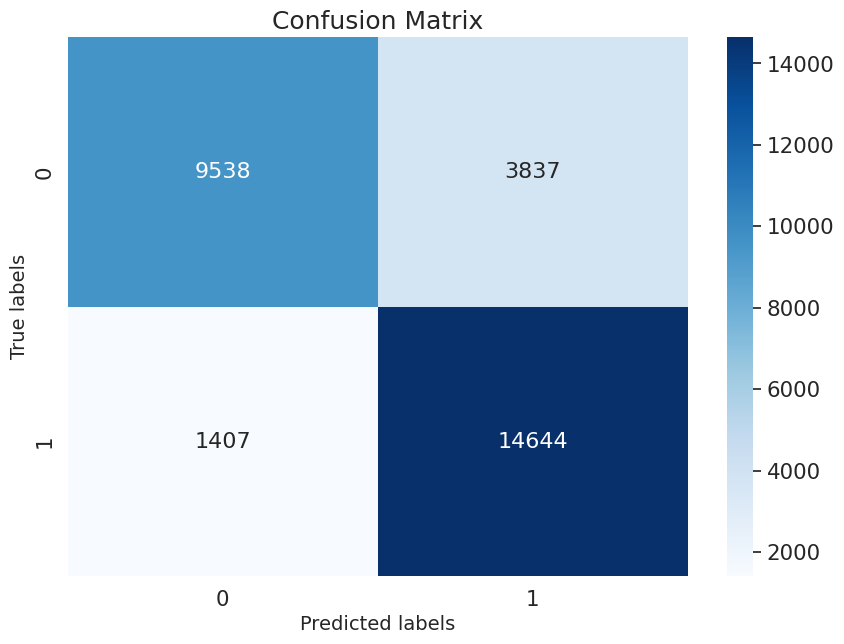

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_prob = result2.predict(X_with_intercept2)
y_pred_class = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues")

label_font = {'size':'14'}
plt.xlabel('Predicted labels', fontdict=label_font)
plt.ylabel('True labels', fontdict=label_font)
plt.title('Confusion Matrix', fontdict={'size':18})

plt.show()